# KdV Equation Comparison: PINN vs Numerical

In [1]:
#!/usr/bin/env python3
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401
import torch
import torch.nn as nn
import torch.optim as optim
from scipy.integrate import solve_ivp
import time

In [2]:
torch.__version__

'2.6.0'

Computing baseline solution with solve_ivp
Epoch    1 | PDE 7.15e-04 | IC 5.01e-01 | BC 1.27e-02 | Tot 5.14e+01
Epoch 1000 | PDE 7.42e-01 | IC 1.40e-03 | BC 3.12e-03 | Tot 1.19e+00
Epoch 2000 | PDE 1.58e-01 | IC 2.81e-04 | BC 1.50e-04 | Tot 2.01e-01
Epoch 3000 | PDE 8.07e-02 | IC 3.81e-04 | BC 6.37e-04 | Tot 1.82e-01
Epoch 4000 | PDE 4.50e-02 | IC 5.91e-05 | BC 2.85e-05 | Tot 5.38e-02
Epoch 5000 | PDE 4.80e-02 | IC 2.87e-04 | BC 1.18e-04 | Tot 8.85e-02
Epoch 6000 | PDE 1.34e-02 | IC 4.09e-05 | BC 4.72e-05 | Tot 2.22e-02
Epoch 7000 | PDE 2.32e-02 | IC 4.78e-04 | BC 4.76e-04 | Tot 1.19e-01
Epoch 8000 | PDE 4.01e-01 | IC 8.84e-04 | BC 7.27e-05 | Tot 4.97e-01
Epoch 9000 | PDE 9.77e-02 | IC 3.47e-04 | BC 5.10e-05 | Tot 1.37e-01
Epoch 10000 | PDE 1.17e-01 | IC 1.16e-03 | BC 4.24e-05 | Tot 2.37e-01


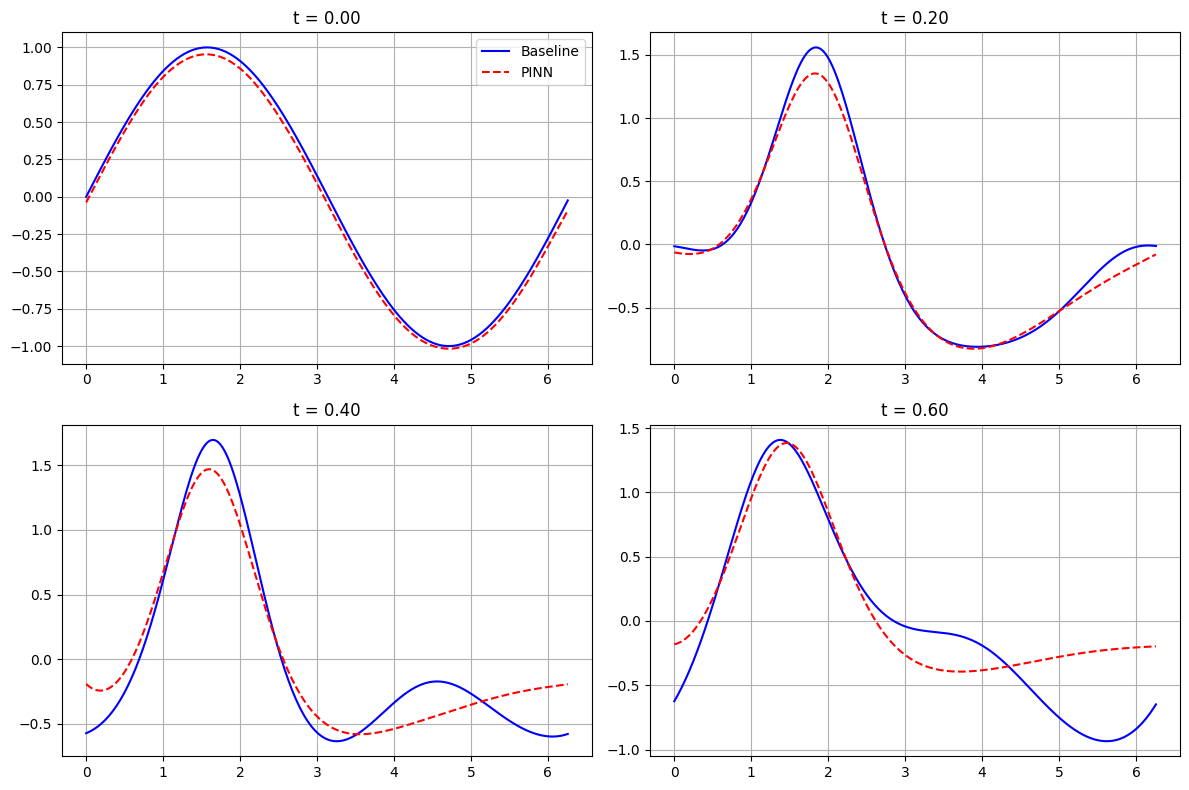

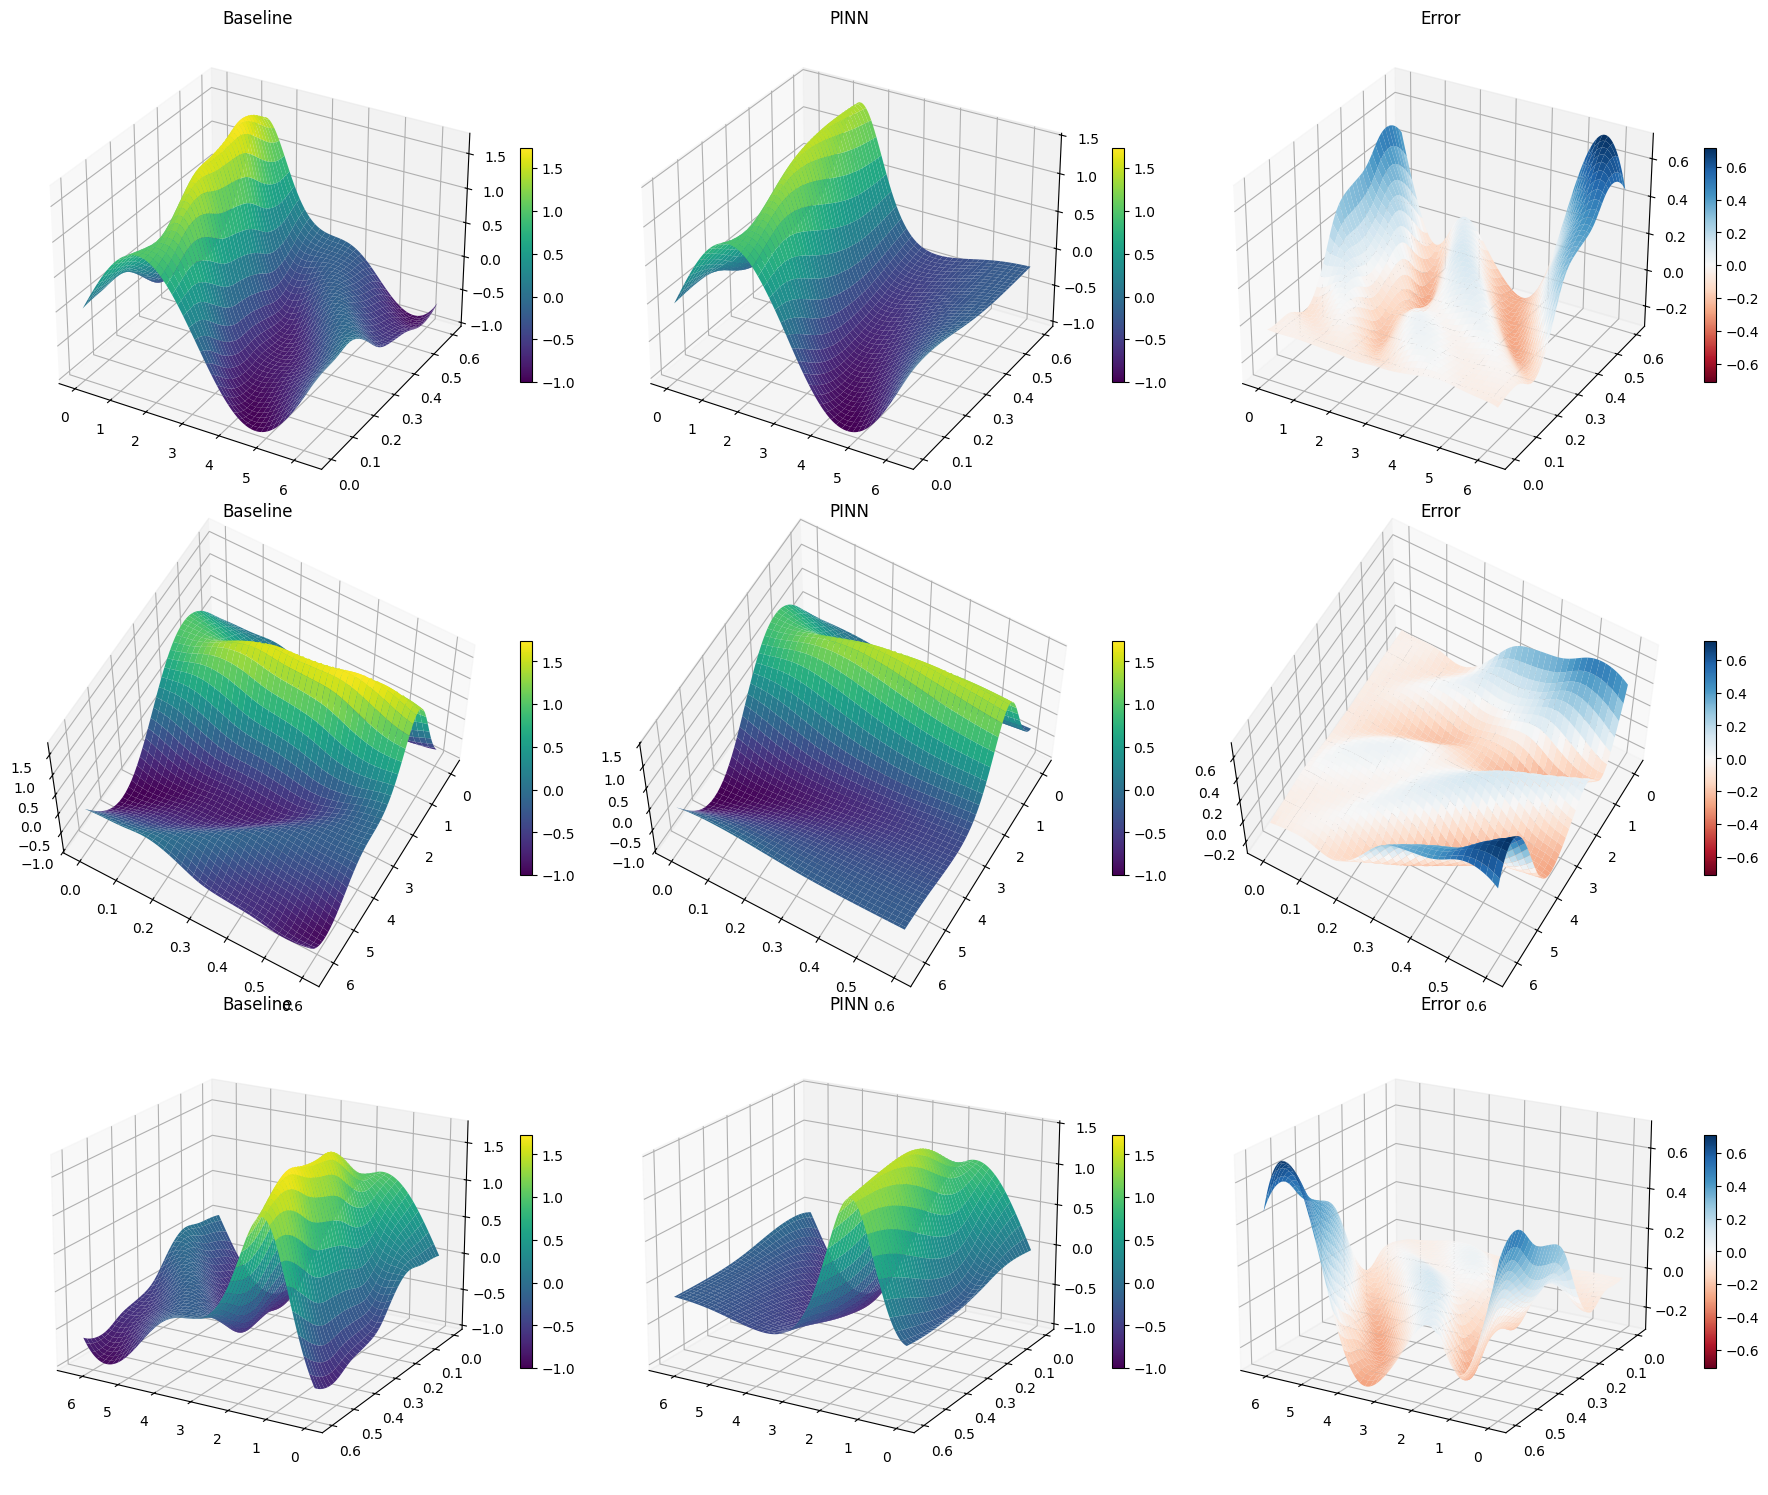

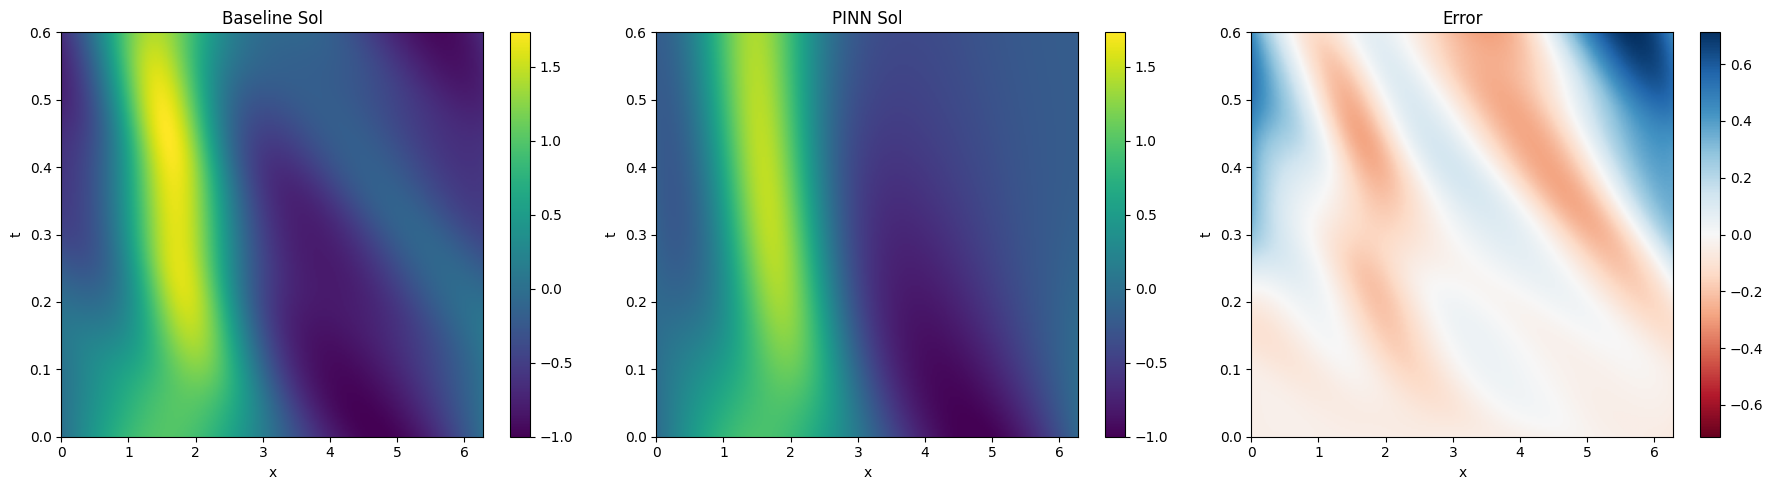

In [24]:
# ----------------------------------------
# 1) Reliable baseline solver for KdV via pseudo-spectral + BDF
# ----------------------------------------

def kdv_rhs(t, u, k):
    """Right-hand side for u_t = -6*u*u_x - u_xxx on a periodic domain."""
    u_hat = np.fft.fft(u)
    u_x   = np.fft.ifft(1j * k * u_hat).real
    u_xxx = np.fft.ifft((1j * k)**3 * u_hat).real
    return -6.0 * u * u_x - u_xxx

# ----------------------------------------
# 2) PINN definition (unchanged)
# ----------------------------------------
class MLP(nn.Module):
    def __init__(self, in_dim, hidden_dim, out_dim):
        super().__init__()
        layers = [nn.Linear(in_dim, hidden_dim), nn.Tanh()]
        for _ in range(3):
            layers += [nn.Linear(hidden_dim, hidden_dim), nn.Tanh()]
        layers.append(nn.Linear(hidden_dim, out_dim))
        self.net = nn.Sequential(*layers)
    def forward(self, x):
        return self.net(x)

class KdV_PINN(nn.Module):
    def __init__(self, T):
        super().__init__()
        self.T = T
        self.model = MLP(2, 512, 1)
    def forward(self, x, t):
        XT = torch.cat([x, t], dim=1)
        return self.model(XT)
    def loss_pde(self, x, t):
        x = x.clone().requires_grad_(True)
        t = t.clone().requires_grad_(True)
        u = self.forward(x, t)
        u_t   = torch.autograd.grad(u, t, grad_outputs=torch.ones_like(u), create_graph=True)[0]
        u_x   = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True)[0]
        u_xx  = torch.autograd.grad(u_x, x, grad_outputs=torch.ones_like(u_x), create_graph=True)[0]
        u_xxx = torch.autograd.grad(u_xx, x, grad_outputs=torch.ones_like(u_xx), create_graph=True)[0]
        res = u_t + 6 * u * u_x + u_xxx
        return torch.mean(res**2)
    def loss_ic(self, x):
        u_pred = self.forward(x, torch.zeros_like(x))
        u_true = torch.sin(x)
        return torch.mean((u_pred - u_true)**2)
    def loss_bc(self, t):
        x0 = torch.zeros_like(t)
        x1 = torch.ones_like(t) * (2 * np.pi)
        u0 = self.forward(x0, t)
        u1 = self.forward(x1, t)
        return torch.mean((u0 - u1)**2)
    def train_model(self, epochs, lr, N_pde, N_ic, N_bc, device):
        self.to(device)
        optimizer = optim.Adam(self.parameters(), lr=lr)
        w_pde, w_ic, w_bc = 1.0, 100.0, 100.0
        history = {'pde': [], 'ic': [], 'bc': [], 'total': []}
        for ep in range(1, epochs+1):
            x_p = torch.rand(N_pde, 1, device=device) * 2 * np.pi
            t_p = torch.rand(N_pde, 1, device=device) * self.T
            x_i = torch.rand(N_ic, 1, device=device) * 2 * np.pi
            t_b = torch.rand(N_bc, 1, device=device) * self.T
            l_pde = self.loss_pde(x_p, t_p)
            l_ic  = self.loss_ic(x_i)
            l_bc  = self.loss_bc(t_b)
            loss  = w_pde * l_pde + w_ic * l_ic + w_bc * l_bc
            optimizer.zero_grad(); loss.backward(); optimizer.step()
            history['pde'].append(l_pde.item())
            history['ic'].append(l_ic.item())
            history['bc'].append(l_bc.item())
            history['total'].append(loss.item())
            if ep == 1 or ep % 1000 == 0:
                print(f"Epoch {ep:4d} | PDE {l_pde:.2e} | IC {l_ic:.2e} | BC {l_bc:.2e} | Tot {loss:.2e}")
        return history

# ----------------------------------------
# 3) Main: baseline solver + PINN + visualization
# ----------------------------------------
if __name__ == "__main__":
    # Domain parameters
    Lx = 2 * np.pi
    Nx = 256
    T  = 0.6
    t_points = 201

    # Spatial grid & initial condition
    x = np.linspace(0, Lx, Nx, endpoint=False)
    u0 = np.sin(x)

    # Baseline numerical solution via solve_ivp
    k = 2*np.pi * np.fft.fftfreq(Nx, d=Lx/Nx)
    t_eval = np.linspace(0, T, t_points)
    print("Computing baseline solution with solve_ivp")
    sol = solve_ivp(lambda t, u: kdv_rhs(t, u, k), [0, T], u0,
                     method='BDF', t_eval=t_eval, rtol=1e-6, atol=1e-8)
    # dt = T / (t_points-1)
    # usol = etdrk4_kdv(u0, k, dt, t_points-1)
    usol = sol.y.T  # shape (t_points, Nx)

    # Train PINN
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    pinn = KdV_PINN(T)
    history = pinn.train_model(epochs=10000, lr=1e-3, N_pde=3000, N_ic=500, N_bc=500, device=device)

    # Evaluate PINN on full mesh
    T2D, X2D = np.meshgrid(t_eval, x, indexing='ij')
    X_flat = torch.tensor(X2D.reshape(-1,1), dtype=torch.float32, device=device)
    T_flat = torch.tensor(T2D.reshape(-1,1), dtype=torch.float32, device=device)
    with torch.no_grad():
        u_pinn = pinn(X_flat, T_flat).cpu().numpy().reshape(t_points, Nx)

    # Compute error
    err = u_pinn - usol
    emax = np.max(np.abs(err))

    # Plot baseline vs PINN cross-sections
    fig_cs, axes_cs = plt.subplots(2, 2, figsize=(12,8))
    times = [0.0, 0.2, 0.4, 0.6]
    for ax, tval in zip(axes_cs.flatten(), times):
        idx = np.searchsorted(t_eval, tval)
        ax.plot(x, usol[idx], 'b-', label='Baseline')
        ax.plot(x, u_pinn[idx], 'r--', label='PINN')
        ax.set_title(f't = {tval:.2f}'); ax.grid(True)
    axes_cs[0,0].legend(); plt.tight_layout()

    # 3D visualizations from multiple angles
    angles = [(30, -60), (60, 30), (20, 120)]
    fig_multi = plt.figure(figsize=(18, 5*len(angles)))
    for i, (elev, azim) in enumerate(angles, 1):
        ax = fig_multi.add_subplot(len(angles), 3, 3*(i-1)+1, projection='3d')
        surf1 = ax.plot_surface(X2D, T2D, usol, cmap='viridis', vmin=usol.min(), vmax=usol.max())
        ax.view_init(elev=elev, azim=azim); ax.set_title(f'Baseline')
        fig_multi.colorbar(surf1, ax=ax, shrink=0.5)

        ax2 = fig_multi.add_subplot(len(angles), 3, 3*(i-1)+2, projection='3d')
        surf2 = ax2.plot_surface(X2D, T2D, u_pinn, cmap='viridis', vmin=usol.min(), vmax=usol.max())
        ax2.view_init(elev=elev, azim=azim); ax2.set_title(f'PINN')
        fig_multi.colorbar(surf2, ax=ax2, shrink=0.5)

        ax3 = fig_multi.add_subplot(len(angles), 3, 3*(i-1)+3, projection='3d')
        surf3 = ax3.plot_surface(X2D, T2D, err, cmap='RdBu', vmin=-emax, vmax=emax)
        ax3.view_init(elev=elev, azim=azim); ax3.set_title(f'Error')
        fig_multi.colorbar(surf3, ax=ax3, shrink=0.5)
    plt.tight_layout(); plt.show()

    # Heatmap comparison
    fig_hm, axes_hm = plt.subplots(1, 3, figsize=(18,5))
    for ax, Z, title, cmap, clim in zip(
        axes_hm,
        [usol, u_pinn, err],
        ['Baseline Sol', 'PINN Sol', 'Error'],
        ['viridis', 'viridis', 'RdBu'],
        [(usol.min(), usol.max()), (usol.min(), usol.max()), (-emax, emax)]
    ):
        im = ax.imshow(Z, aspect='auto', origin='lower', extent=[0, Lx, 0, T], cmap=cmap, vmin=clim[0], vmax=clim[1])
        ax.set_title(title); ax.set_xlabel('x'); ax.set_ylabel('t')
        fig_hm.colorbar(im, ax=ax)
    plt.tight_layout(); plt.show()


Computing baseline solution with solve_ivp
Epoch    1 | PDE 1.89e-04 | IC 5.14e-01 | BC 6.18e-04 | Tot 5.15e+01
Epoch 1000 | PDE 7.00e-01 | IC 1.19e-03 | BC 4.70e-04 | Tot 8.66e-01
Epoch 2000 | PDE 1.87e-01 | IC 8.64e-04 | BC 2.51e-03 | Tot 5.24e-01
Epoch 3000 | PDE 8.68e-02 | IC 1.56e-04 | BC 1.85e-04 | Tot 1.21e-01
Epoch 4000 | PDE 6.99e-02 | IC 2.29e-04 | BC 3.99e-04 | Tot 1.33e-01
Epoch 5000 | PDE 1.81e-02 | IC 6.07e-04 | BC 1.01e-03 | Tot 1.80e-01
Epoch 6000 | PDE 1.93e-02 | IC 5.03e-05 | BC 6.84e-06 | Tot 2.50e-02
Epoch 7000 | PDE 1.12e-02 | IC 2.91e-05 | BC 9.03e-06 | Tot 1.50e-02
Epoch 8000 | PDE 7.93e-03 | IC 1.42e-04 | BC 1.87e-04 | Tot 4.09e-02
Epoch 9000 | PDE 1.31e-02 | IC 1.35e-04 | BC 1.25e-04 | Tot 3.91e-02
Total script execution time: 74.00 minutes.


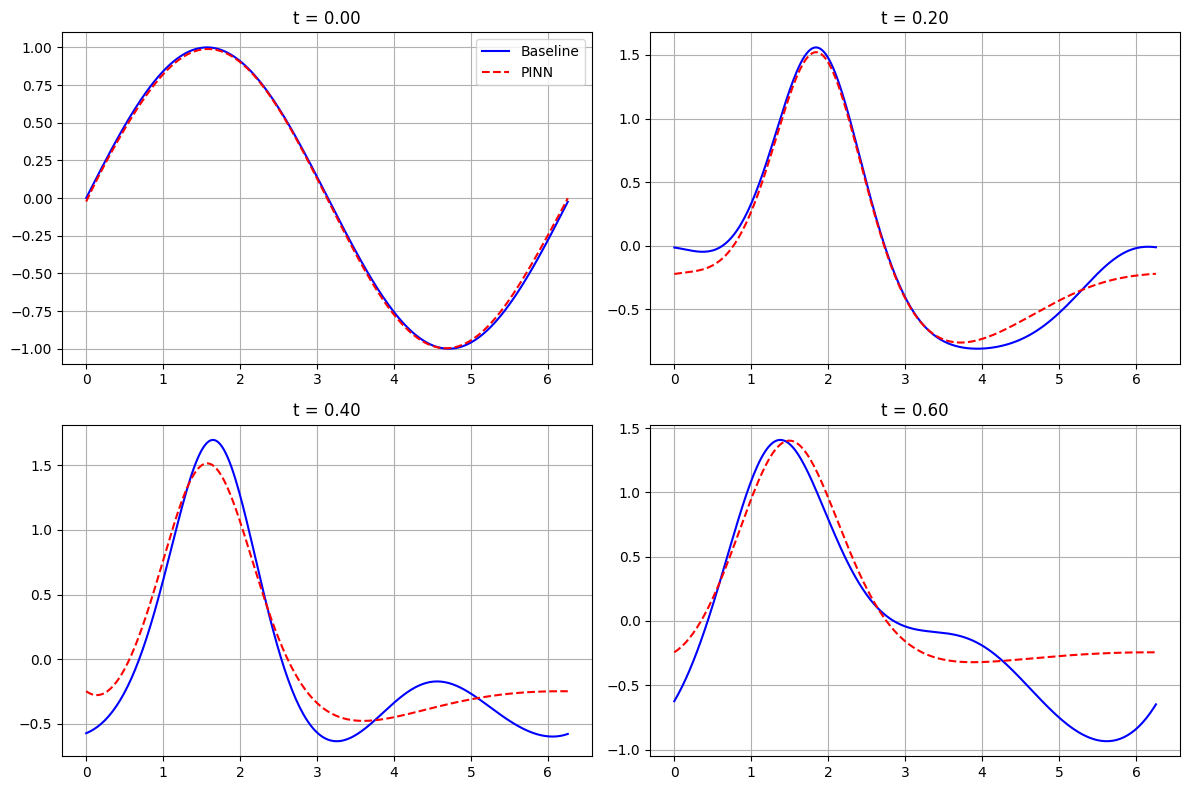

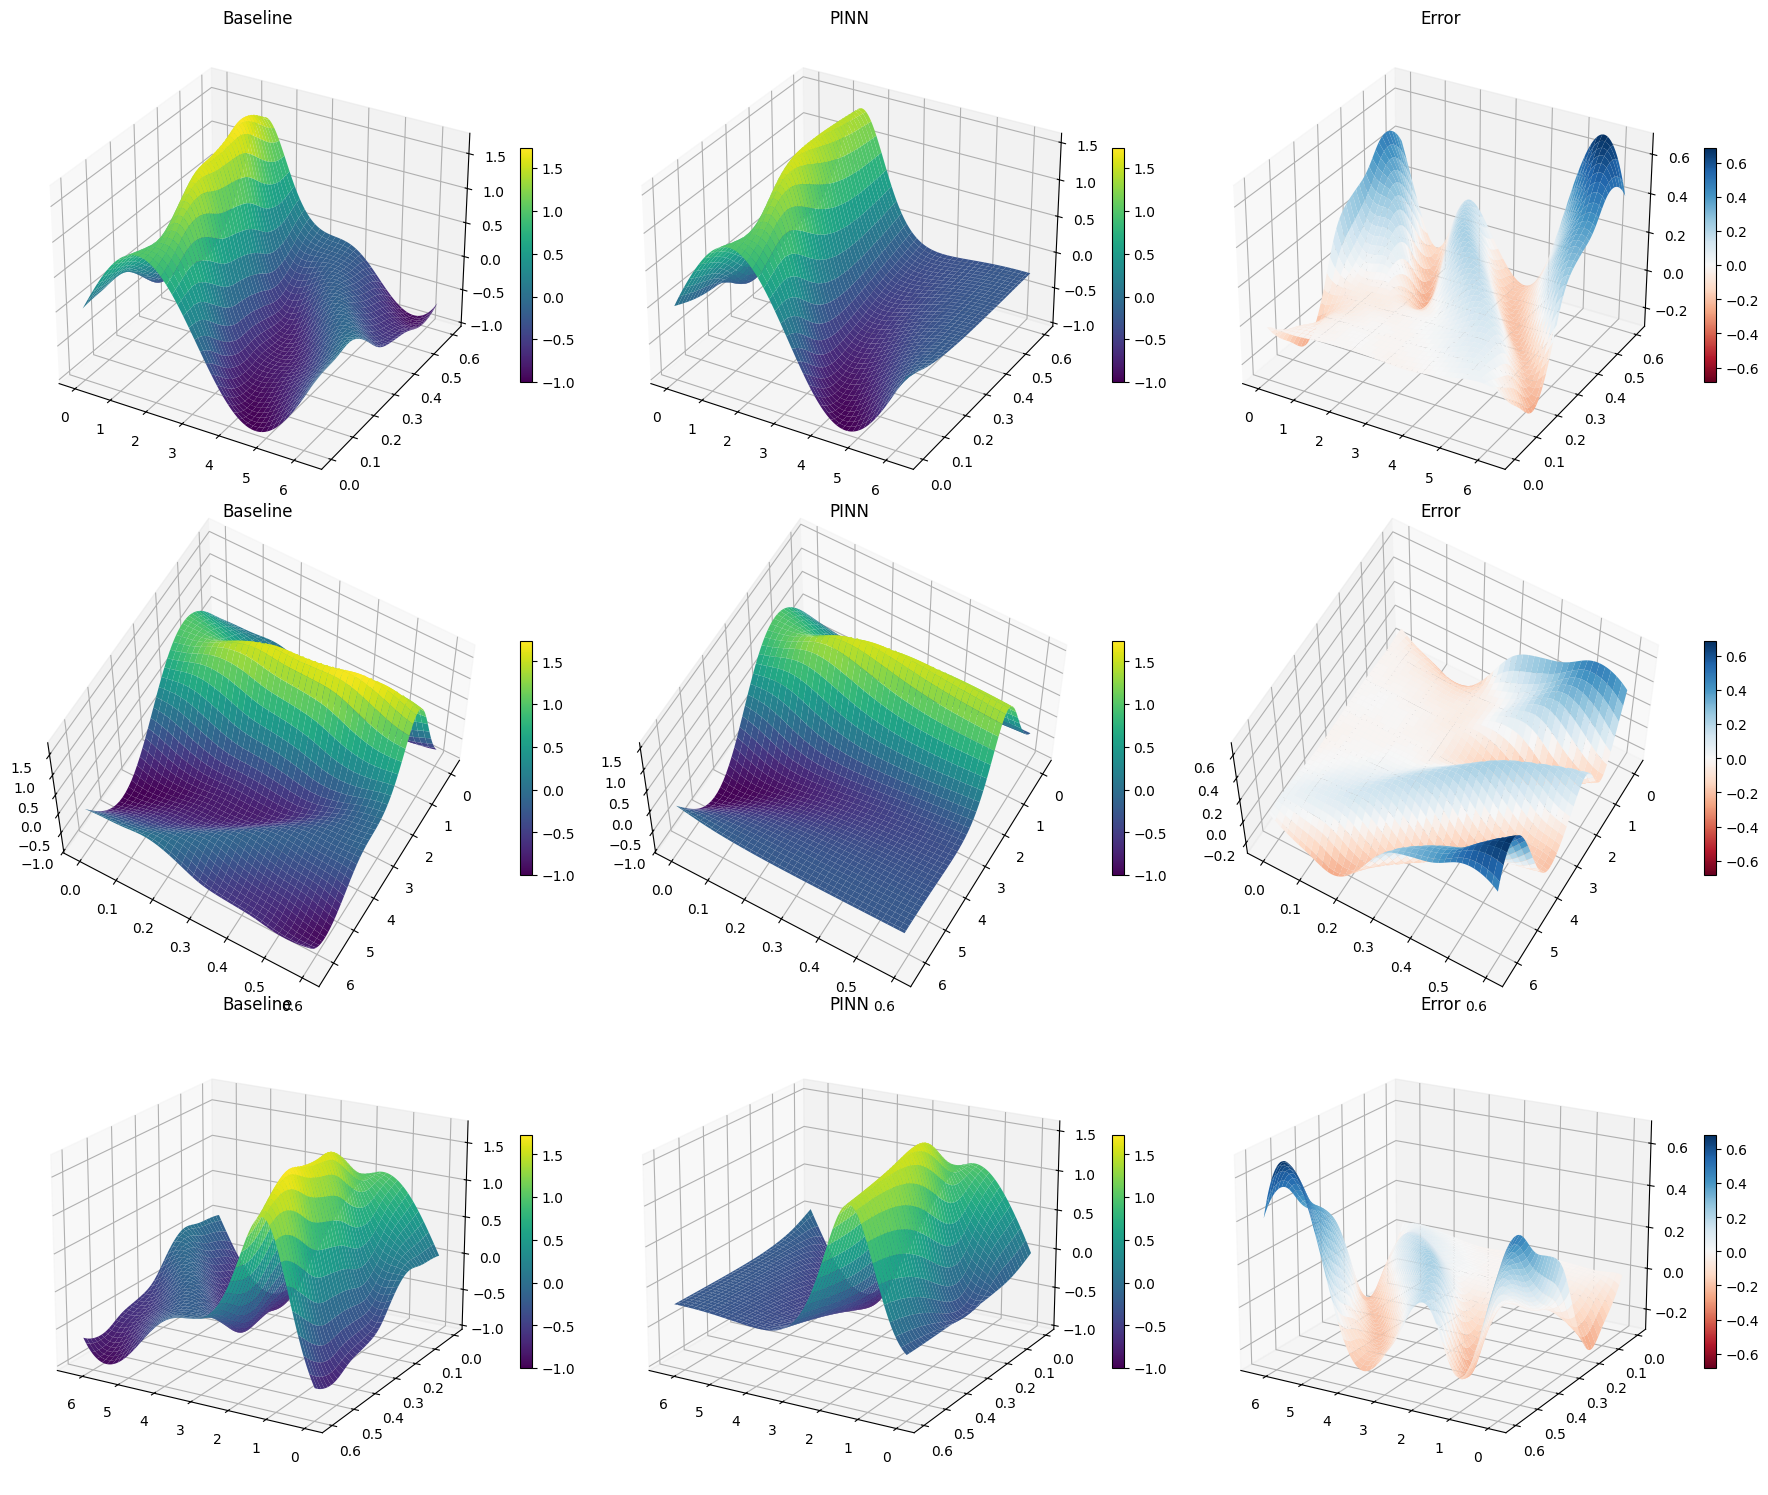

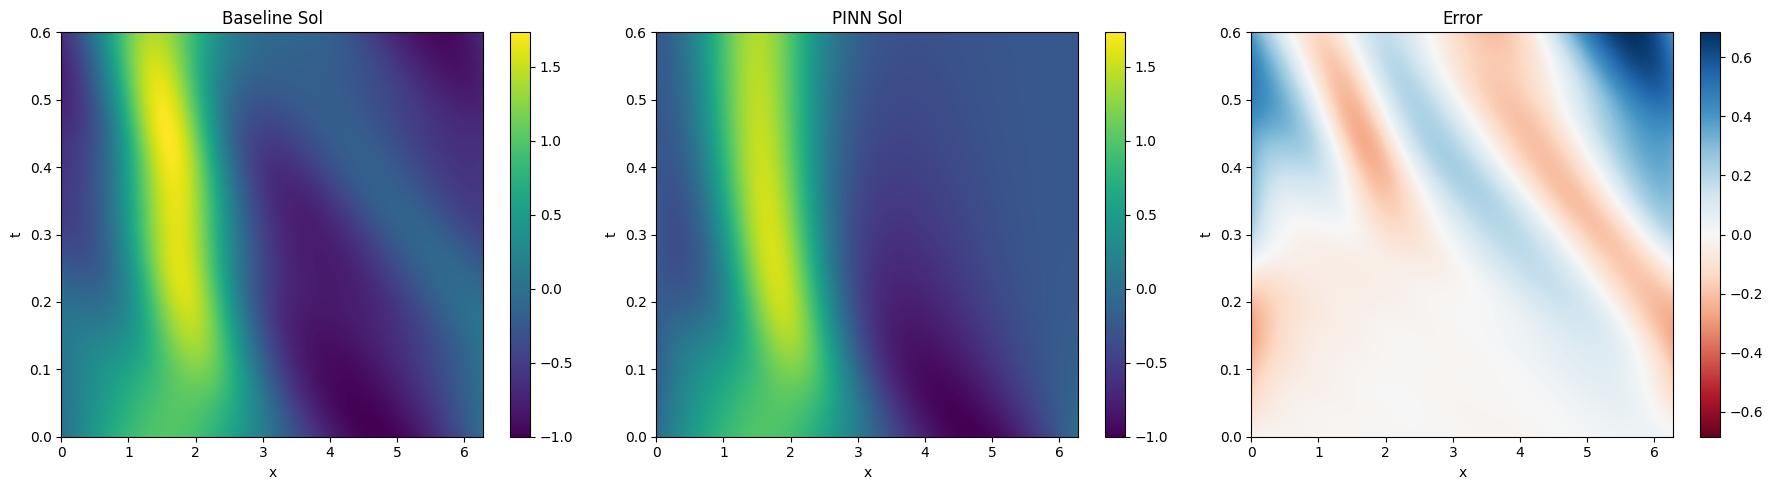

In [2]:

# ----------------------------------------
# 1) Reliable baseline solver for KdV via pseudo-spectral + BDF
# ----------------------------------------

def kdv_rhs(t, u, k):
    """Right-hand side for u_t = -6*u*u_x - u_xxx on a periodic domain."""
    u_hat = np.fft.fft(u)
    u_x   = np.fft.ifft(1j * k * u_hat).real
    u_xxx = np.fft.ifft((1j * k)**3 * u_hat).real
    return -6.0 * u * u_x - u_xxx

# ----------------------------------------
# 2) PINN definition
# ----------------------------------------
class MLP(nn.Module):
    def __init__(self, in_dim, hidden_dim, out_dim):
        super().__init__()
        layers = [nn.Linear(in_dim, hidden_dim), nn.Tanh()]
        for _ in range(3):
            layers += [nn.Linear(hidden_dim, hidden_dim), nn.Tanh()]
        layers.append(nn.Linear(hidden_dim, out_dim))
        self.net = nn.Sequential(*layers)
    def forward(self, x):
        return self.net(x)

class KdV_PINN(nn.Module):
    def __init__(self, T):
        super().__init__()
        self.T = T
        self.model = MLP(2, 512, 1)
    def forward(self, x, t):
        XT = torch.cat([x, t], dim=1)
        return self.model(XT)
    def loss_pde(self, x, t):
        x = x.clone().requires_grad_(True)
        t = t.clone().requires_grad_(True)
        u = self.forward(x, t)
        u_t   = torch.autograd.grad(u, t, grad_outputs=torch.ones_like(u), create_graph=True)[0]
        u_x   = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True)[0]
        u_xx  = torch.autograd.grad(u_x, x, grad_outputs=torch.ones_like(u_x), create_graph=True)[0]
        u_xxx = torch.autograd.grad(u_xx, x, grad_outputs=torch.ones_like(u_xx), create_graph=True)[0]
        res = u_t + 6 * u * u_x + u_xxx
        return torch.mean(res**2)
    def loss_ic(self, x):
        u_pred = self.forward(x, torch.zeros_like(x))
        u_true = torch.sin(x)
        return torch.mean((u_pred - u_true)**2)
    def loss_bc(self, t):
        x0 = torch.zeros_like(t)
        x1 = torch.ones_like(t) * (2 * np.pi)
        u0 = self.forward(x0, t)
        u1 = self.forward(x1, t)
        return torch.mean((u0 - u1)**2)
    def train_model(self, epochs, lr, N_pde, N_ic, N_bc, device):
        self.to(device)
        optimizer = optim.Adam(self.parameters(), lr=lr)
        w_pde, w_ic, w_bc = 1.0, 100.0, 100.0
        history = {'pde': [], 'ic': [], 'bc': [], 'total': []}
        for ep in range(1, epochs+1):
            x_p = torch.rand(N_pde, 1, device=device) * 2 * np.pi
            t_p = torch.rand(N_pde, 1, device=device) * self.T
            x_i = torch.rand(N_ic, 1, device=device) * 2 * np.pi
            t_b = torch.rand(N_bc, 1, device=device) * self.T
            l_pde = self.loss_pde(x_p, t_p)
            l_ic  = self.loss_ic(x_i)
            l_bc  = self.loss_bc(t_b)
            loss  = w_pde * l_pde + w_ic * l_ic + w_bc * l_bc
            optimizer.zero_grad(); loss.backward(); optimizer.step()
            history['pde'].append(l_pde.item())
            history['ic'].append(l_ic.item())
            history['bc'].append(l_bc.item())
            history['total'].append(loss.item())
            if ep == 1 or ep % 1000 == 0:
                print(f"Epoch {ep:4d} | PDE {l_pde:.2e} | IC {l_ic:.2e} | BC {l_bc:.2e} | Tot {loss:.2e}")
        return history

# ----------------------------------------
# 3) Main: baseline solver + PINN + visualization
# ----------------------------------------
if __name__ == "__main__":
    total_start = time.perf_counter()
    # Domain parameters
    Lx = 2 * np.pi
    Nx = 256
    T  = 0.6
    t_points = 201

    # Spatial grid & initial condition
    x = np.linspace(0, Lx, Nx, endpoint=False)
    u0 = np.sin(x)

    # Baseline numerical solution via solve_ivp
    k = 2*np.pi * np.fft.fftfreq(Nx, d=Lx/Nx)
    t_eval = np.linspace(0, T, t_points)
    print("Computing baseline solution with solve_ivp")
    sol = solve_ivp(lambda t, u: kdv_rhs(t, u, k), [0, T], u0,
                     method='BDF', t_eval=t_eval, rtol=1e-6, atol=1e-8)
    # dt = T / (t_points-1)
    # usol = etdrk4_kdv(u0, k, dt, t_points-1)
    usol = sol.y.T  # shape (t_points, Nx)

    # Train PINN
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    pinn = KdV_PINN(T)
    history = pinn.train_model(epochs=9000, lr=1e-3, N_pde=5000, N_ic=600, N_bc=600, device=device)

    # Evaluate PINN on full mesh
    T2D, X2D = np.meshgrid(t_eval, x, indexing='ij')
    X_flat = torch.tensor(X2D.reshape(-1,1), dtype=torch.float32, device=device)
    T_flat = torch.tensor(T2D.reshape(-1,1), dtype=torch.float32, device=device)
    with torch.no_grad():
        u_pinn = pinn(X_flat, T_flat).cpu().numpy().reshape(t_points, Nx)

    # Compute error
    err = u_pinn - usol
    emax = np.max(np.abs(err))

    total_end = time.perf_counter()
    print(f"Total script execution time: {(total_end - total_start)/60:.2f} minutes.")

    # Plot baseline vs PINN cross-sections
    fig_cs, axes_cs = plt.subplots(2, 2, figsize=(12,8))
    times = [0.0, 0.2, 0.4, 0.6]
    for ax, tval in zip(axes_cs.flatten(), times):
        idx = np.searchsorted(t_eval, tval)
        ax.plot(x, usol[idx], 'b-', label='Baseline')
        ax.plot(x, u_pinn[idx], 'r--', label='PINN')
        ax.set_title(f't = {tval:.2f}'); ax.grid(True)
    axes_cs[0,0].legend(); plt.tight_layout()

    # 3D visualizations from multiple angles
    angles = [(30, -60), (60, 30), (20, 120)]
    fig_multi = plt.figure(figsize=(18, 5*len(angles)))
    for i, (elev, azim) in enumerate(angles, 1):
        ax = fig_multi.add_subplot(len(angles), 3, 3*(i-1)+1, projection='3d')
        surf1 = ax.plot_surface(X2D, T2D, usol, cmap='viridis', vmin=usol.min(), vmax=usol.max())
        ax.view_init(elev=elev, azim=azim); ax.set_title(f'Baseline')
        fig_multi.colorbar(surf1, ax=ax, shrink=0.5)

        ax2 = fig_multi.add_subplot(len(angles), 3, 3*(i-1)+2, projection='3d')
        surf2 = ax2.plot_surface(X2D, T2D, u_pinn, cmap='viridis', vmin=usol.min(), vmax=usol.max())
        ax2.view_init(elev=elev, azim=azim); ax2.set_title(f'PINN')
        fig_multi.colorbar(surf2, ax=ax2, shrink=0.5)

        ax3 = fig_multi.add_subplot(len(angles), 3, 3*(i-1)+3, projection='3d')
        surf3 = ax3.plot_surface(X2D, T2D, err, cmap='RdBu', vmin=-emax, vmax=emax)
        ax3.view_init(elev=elev, azim=azim); ax3.set_title(f'Error')
        fig_multi.colorbar(surf3, ax=ax3, shrink=0.5)
    plt.tight_layout(); plt.show()

    # Heatmap comparison
    fig_hm, axes_hm = plt.subplots(1, 3, figsize=(18,5))
    for ax, Z, title, cmap, clim in zip(
        axes_hm,
        [usol, u_pinn, err],
        ['Baseline Sol', 'PINN Sol', 'Error'],
        ['viridis', 'viridis', 'RdBu'],
        [(usol.min(), usol.max()), (usol.min(), usol.max()), (-emax, emax)]
    ):
        im = ax.imshow(Z, aspect='auto', origin='lower', extent=[0, Lx, 0, T], cmap=cmap, vmin=clim[0], vmax=clim[1])
        ax.set_title(title); ax.set_xlabel('x'); ax.set_ylabel('t')
        fig_hm.colorbar(im, ax=ax)
    plt.tight_layout(); plt.show()


Computing baseline solution with solve_ivp
Epoch    1 | PDE 5.09e-05 | IC 4.96e-01 | BC 8.85e-05 | Tot 4.96e+01
Epoch 1000 | PDE 7.77e-01 | IC 1.53e-03 | BC 3.07e-04 | Tot 9.61e-01
Epoch 2000 | PDE 2.79e-01 | IC 5.56e-04 | BC 4.25e-04 | Tot 3.77e-01
Epoch 3000 | PDE 7.30e-01 | IC 1.32e-02 | BC 3.86e-03 | Tot 2.44e+00
Epoch 4000 | PDE 3.48e-02 | IC 5.40e-05 | BC 2.03e-05 | Tot 4.22e-02
Epoch 5000 | PDE 4.54e-02 | IC 8.88e-04 | BC 1.81e-04 | Tot 1.52e-01
Epoch 6000 | PDE 5.96e-02 | IC 6.62e-04 | BC 3.25e-04 | Tot 1.58e-01
Epoch 7000 | PDE 3.70e-02 | IC 3.52e-04 | BC 7.94e-05 | Tot 8.01e-02
Epoch 8000 | PDE 9.00e-03 | IC 7.06e-06 | BC 7.65e-06 | Tot 1.05e-02
Epoch 9000 | PDE 1.09e-01 | IC 4.96e-04 | BC 6.80e-05 | Tot 1.65e-01
Total script execution time: 70.11 minutes.


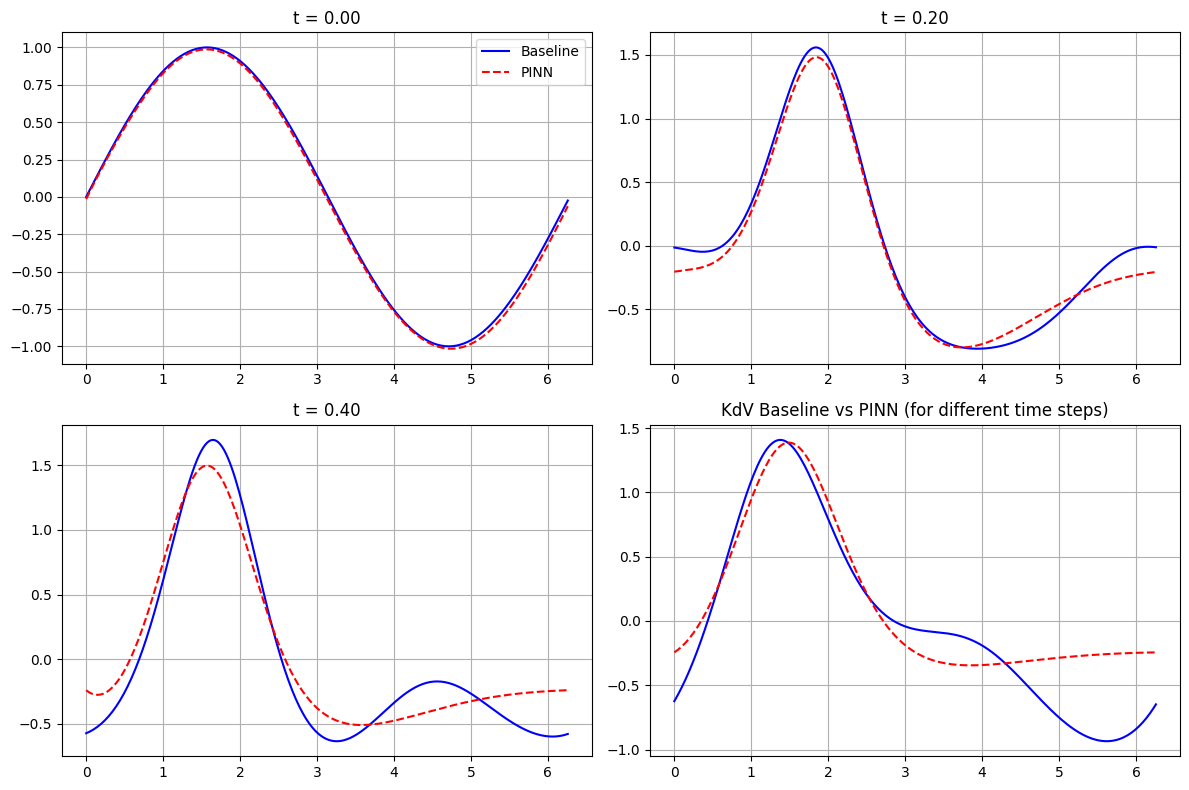

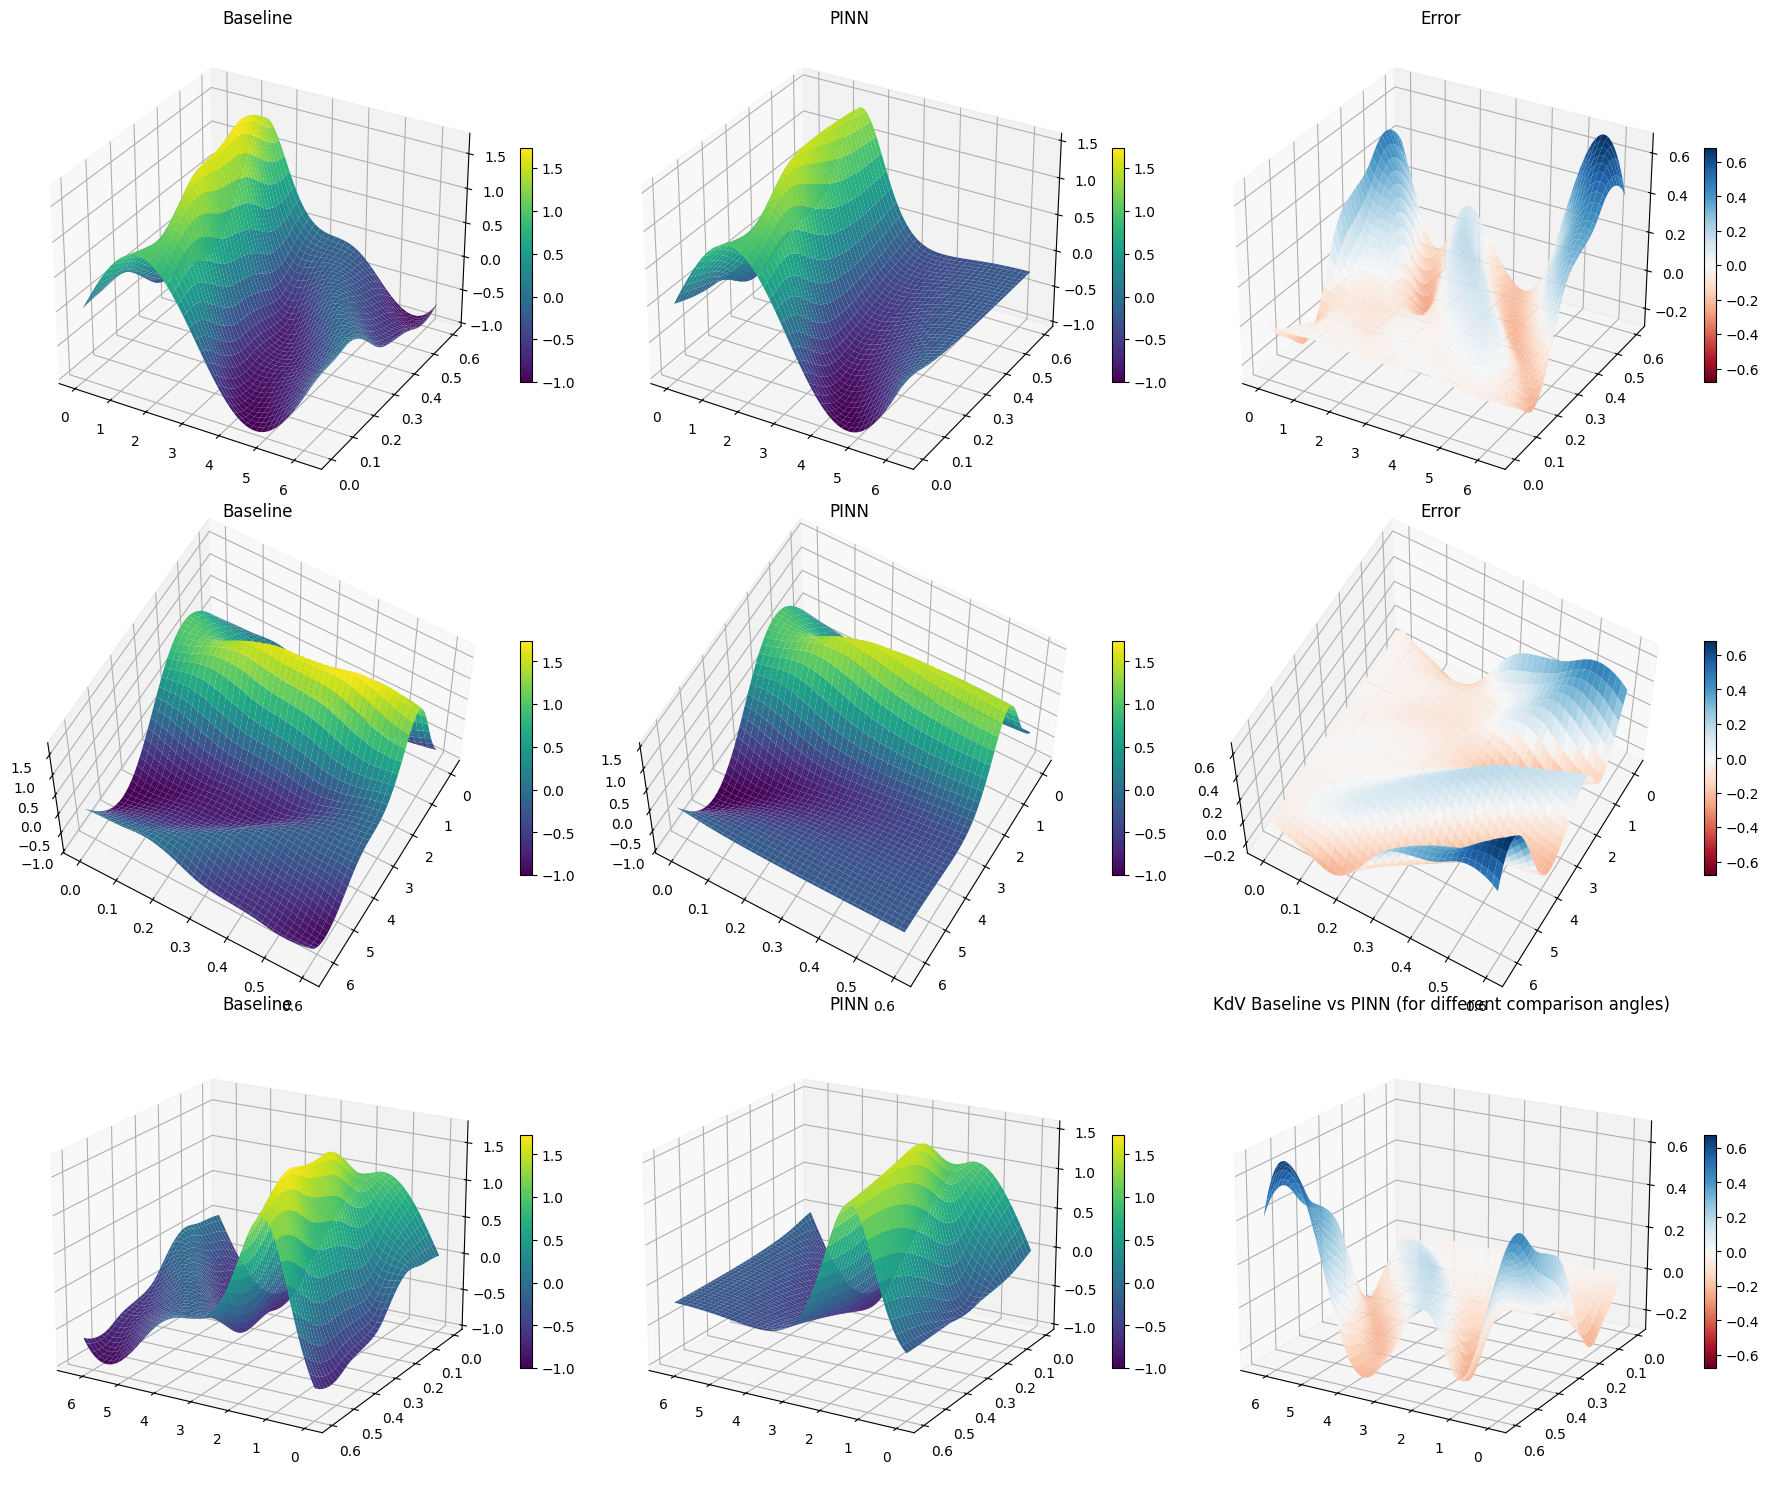

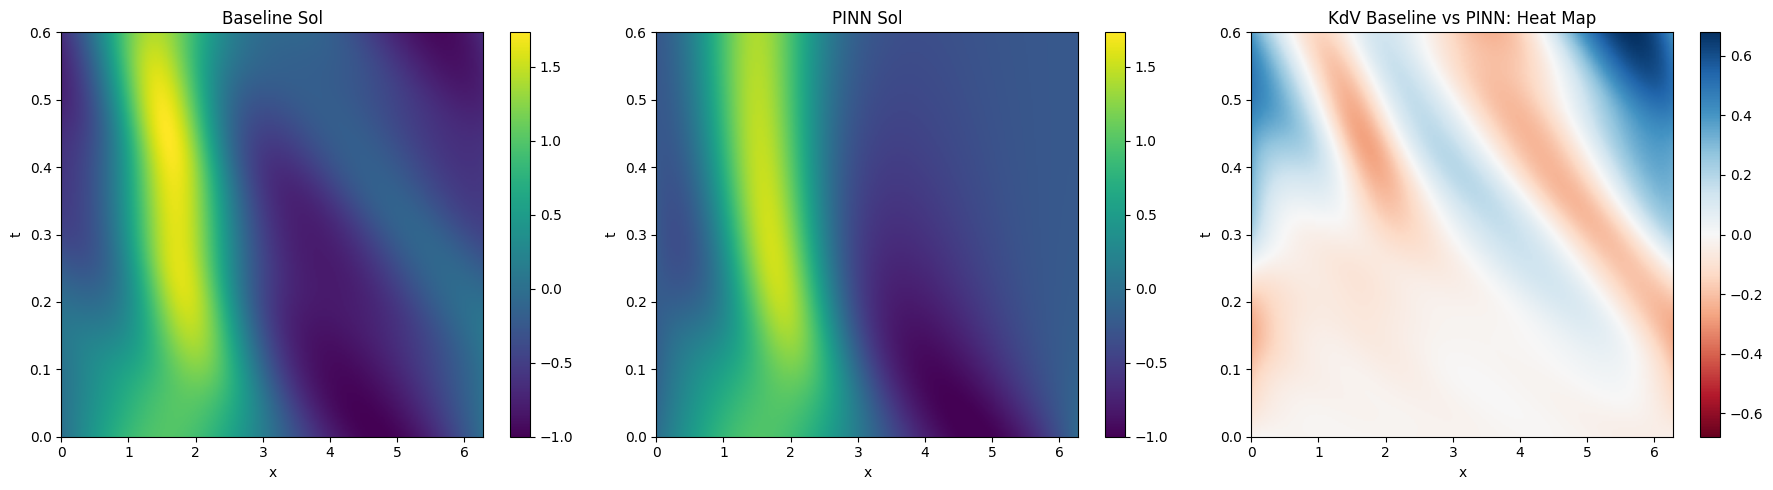

In [3]:

# ----------------------------------------
# 1) Reliable baseline solver for KdV via pseudo-spectral + BDF
# ----------------------------------------

def kdv_rhs(t, u, k):
    """Right-hand side for u_t = -6*u*u_x - u_xxx on a periodic domain."""
    u_hat = np.fft.fft(u)
    u_x   = np.fft.ifft(1j * k * u_hat).real
    u_xxx = np.fft.ifft((1j * k)**3 * u_hat).real
    return -6.0 * u * u_x - u_xxx

# ----------------------------------------
# 2) PINN definition
# ----------------------------------------
class MLP(nn.Module):
    def __init__(self, in_dim, hidden_dim, out_dim):
        super().__init__()
        layers = [nn.Linear(in_dim, hidden_dim), nn.Tanh()]
        for _ in range(3):
            layers += [nn.Linear(hidden_dim, hidden_dim), nn.Tanh()]
        layers.append(nn.Linear(hidden_dim, out_dim))
        self.net = nn.Sequential(*layers)
    def forward(self, x):
        return self.net(x)

class KdV_PINN(nn.Module):
    def __init__(self, T):
        super().__init__()
        self.T = T
        self.model = MLP(2, 512, 1)
    def forward(self, x, t):
        XT = torch.cat([x, t], dim=1)
        return self.model(XT)
    def loss_pde(self, x, t):
        x = x.clone().requires_grad_(True)
        t = t.clone().requires_grad_(True)
        u = self.forward(x, t)
        u_t   = torch.autograd.grad(u, t, grad_outputs=torch.ones_like(u), create_graph=True)[0]
        u_x   = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True)[0]
        u_xx  = torch.autograd.grad(u_x, x, grad_outputs=torch.ones_like(u_x), create_graph=True)[0]
        u_xxx = torch.autograd.grad(u_xx, x, grad_outputs=torch.ones_like(u_xx), create_graph=True)[0]
        res = u_t + 6 * u * u_x + u_xxx
        return torch.mean(res**2)
    def loss_ic(self, x):
        u_pred = self.forward(x, torch.zeros_like(x))
        u_true = torch.sin(x)
        return torch.mean((u_pred - u_true)**2)
    def loss_bc(self, t):
        x0 = torch.zeros_like(t)
        x1 = torch.ones_like(t) * (2 * np.pi)
        u0 = self.forward(x0, t)
        u1 = self.forward(x1, t)
        return torch.mean((u0 - u1)**2)
    def train_model(self, epochs, lr, N_pde, N_ic, N_bc, device):
        self.to(device)
        optimizer = optim.Adam(self.parameters(), lr=lr)
        w_pde, w_ic, w_bc = 45.0, 50.0, 40.0
        history = {'pde': [], 'ic': [], 'bc': [], 'total': []}
        for ep in range(1, epochs+1):
            x_p = torch.rand(N_pde, 1, device=device) * 2 * np.pi
            t_p = torch.rand(N_pde, 1, device=device) * self.T
            x_i = torch.rand(N_ic, 1, device=device) * 2 * np.pi
            t_b = torch.rand(N_bc, 1, device=device) * self.T
            l_pde = self.loss_pde(x_p, t_p)
            l_ic  = self.loss_ic(x_i)
            l_bc  = self.loss_bc(t_b)
            loss  = w_pde * l_pde + w_ic * l_ic + w_bc * l_bc
            optimizer.zero_grad(); loss.backward(); optimizer.step()
            history['pde'].append(l_pde.item())
            history['ic'].append(l_ic.item())
            history['bc'].append(l_bc.item())
            history['total'].append(loss.item())
            if ep == 1 or ep % 1000 == 0:
                print(f"Epoch {ep:4d} | PDE {l_pde:.2e} | IC {l_ic:.2e} | BC {l_bc:.2e} | Tot {loss:.2e}")
        return history

# ----------------------------------------
# 3) Main: baseline solver + PINN + visualization
# ----------------------------------------
if __name__ == "__main__":
    total_start = time.perf_counter()
    # Domain parameters
    Lx = 2 * np.pi
    Nx = 256
    T  = 0.6
    t_points = 201

    # Spatial grid & initial condition
    x = np.linspace(0, Lx, Nx, endpoint=False)
    u0 = np.sin(x)

    # Baseline numerical solution via solve_ivp
    k = 2*np.pi * np.fft.fftfreq(Nx, d=Lx/Nx)
    t_eval = np.linspace(0, T, t_points)
    print("Computing baseline solution with solve_ivp")
    sol = solve_ivp(lambda t, u: kdv_rhs(t, u, k), [0, T], u0,
                     method='BDF', t_eval=t_eval, rtol=1e-6, atol=1e-8)
    # dt = T / (t_points-1)
    # usol = etdrk4_kdv(u0, k, dt, t_points-1)
    usol = sol.y.T  # shape (t_points, Nx)

    # Train PINN
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    pinn = KdV_PINN(T)
    history = pinn.train_model(epochs=9000, lr=1e-3, N_pde=5000, N_ic=600, N_bc=600, device=device)

    # Evaluate PINN on full mesh
    T2D, X2D = np.meshgrid(t_eval, x, indexing='ij')
    X_flat = torch.tensor(X2D.reshape(-1,1), dtype=torch.float32, device=device)
    T_flat = torch.tensor(T2D.reshape(-1,1), dtype=torch.float32, device=device)
    with torch.no_grad():
        u_pinn = pinn(X_flat, T_flat).cpu().numpy().reshape(t_points, Nx)

    # Compute error
    err = u_pinn - usol
    emax = np.max(np.abs(err))

    total_end = time.perf_counter()
    print(f"Total script execution time: {(total_end - total_start)/60:.2f} minutes.")

    # Plot baseline vs PINN cross-sections
    fig_cs, axes_cs = plt.subplots(2, 2, figsize=(12,8))
    times = [0.0, 0.2, 0.4, 0.6]
    for ax, tval in zip(axes_cs.flatten(), times):
        idx = np.searchsorted(t_eval, tval)
        ax.plot(x, usol[idx], 'b-', label='Baseline')
        ax.plot(x, u_pinn[idx], 'r--', label='PINN')
        ax.set_title(f't = {tval:.2f}'); ax.grid(True)
    axes_cs[0,0].legend()
    fig_cs.suptitle("KdV Baseline vs PINN (for different time steps)")
    plt.tight_layout(rect=[0, 0, 1, 0.95])

    # 3D visualizations from multiple angles
    angles = [(30, -60), (60, 30), (20, 120)]
    fig_multi = plt.figure(figsize=(18, 5*len(angles)))
    for i, (elev, azim) in enumerate(angles, 1):
        ax = fig_multi.add_subplot(len(angles), 3, 3*(i-1)+1, projection='3d')
        surf1 = ax.plot_surface(X2D, T2D, usol, cmap='viridis', vmin=usol.min(), vmax=usol.max())
        ax.view_init(elev=elev, azim=azim); ax.set_title(f'Baseline')
        fig_multi.colorbar(surf1, ax=ax, shrink=0.5)

        ax2 = fig_multi.add_subplot(len(angles), 3, 3*(i-1)+2, projection='3d')
        surf2 = ax2.plot_surface(X2D, T2D, u_pinn, cmap='viridis', vmin=usol.min(), vmax=usol.max())
        ax2.view_init(elev=elev, azim=azim); ax2.set_title(f'PINN')
        fig_multi.colorbar(surf2, ax=ax2, shrink=0.5)

        ax3 = fig_multi.add_subplot(len(angles), 3, 3*(i-1)+3, projection='3d')
        surf3 = ax3.plot_surface(X2D, T2D, err, cmap='RdBu', vmin=-emax, vmax=emax)
        ax3.view_init(elev=elev, azim=azim); ax3.set_title(f'Error')
        fig_multi.colorbar(surf3, ax=ax3, shrink=0.5)
    fig_multi.suptitle("KdV Baseline vs PINN (for different comparison angles)")
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

    # Heatmap comparison
    fig_hm, axes_hm = plt.subplots(1, 3, figsize=(18,5))
    for ax, Z, title, cmap, clim in zip(
        axes_hm,
        [usol, u_pinn, err],
        ['Baseline Sol', 'PINN Sol', 'Error'],
        ['viridis', 'viridis', 'RdBu'],
        [(usol.min(), usol.max()), (usol.min(), usol.max()), (-emax, emax)]
    ):
        im = ax.imshow(Z, aspect='auto', origin='lower', extent=[0, Lx, 0, T], cmap=cmap, vmin=clim[0], vmax=clim[1])
        ax.set_title(title); ax.set_xlabel('x'); ax.set_ylabel('t')
        fig_hm.colorbar(im, ax=ax)
    fig_hm.suptitle("KdV Baseline vs PINN: Heat Map")
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

    # --- Loss history plot ---
    fig_loss, ax_loss = plt.subplots(figsize=(6,4))
    ax_loss.plot(history['total'], label='Total Loss')
    ax_loss.plot(history['pde'],   label='PDE Loss')
    ax_loss.plot(history['ic'],    label='IC Loss')
    ax_loss.plot(history['bc'],    label='BC Loss')
    ax_loss.set_yscale('log')
    ax_loss.set_xlabel('Epoch')
    ax_loss.set_ylabel('Loss')
    ax_loss.legend()
    ax_loss.set_title('Training Loss History')
    plt.tight_layout()
    plt.show()


Trying another experiment with different parameters: 

Computing baseline solution with solve_ivp
Epoch    1 | PDE 9.12e-03 | IC 4.49e-01 | BC 9.31e-02 | Tot 2.66e+01
Epoch 1000 | PDE 5.33e-02 | IC 1.58e-01 | BC 1.13e-02 | Tot 1.08e+01
Epoch 2000 | PDE 5.80e-02 | IC 1.18e-01 | BC 2.40e-02 | Tot 9.47e+00
Epoch 3000 | PDE 1.55e-02 | IC 8.29e-02 | BC 1.45e-03 | Tot 4.90e+00
Epoch 4000 | PDE 9.94e-03 | IC 6.43e-02 | BC 5.62e-03 | Tot 3.89e+00
Epoch 5000 | PDE 1.27e-02 | IC 4.05e-02 | BC 9.88e-03 | Tot 2.99e+00
Epoch 6000 | PDE 1.12e-02 | IC 2.82e-02 | BC 9.48e-03 | Tot 2.29e+00
Epoch 7000 | PDE 6.78e-03 | IC 2.25e-02 | BC 4.03e-03 | Tot 1.59e+00
Epoch 8000 | PDE 1.31e-02 | IC 8.41e-03 | BC 5.83e-03 | Tot 1.24e+00
Epoch 9000 | PDE 7.07e-03 | IC 7.59e-03 | BC 1.44e-03 | Tot 7.55e-01
Total script execution time: 69.26 minutes.


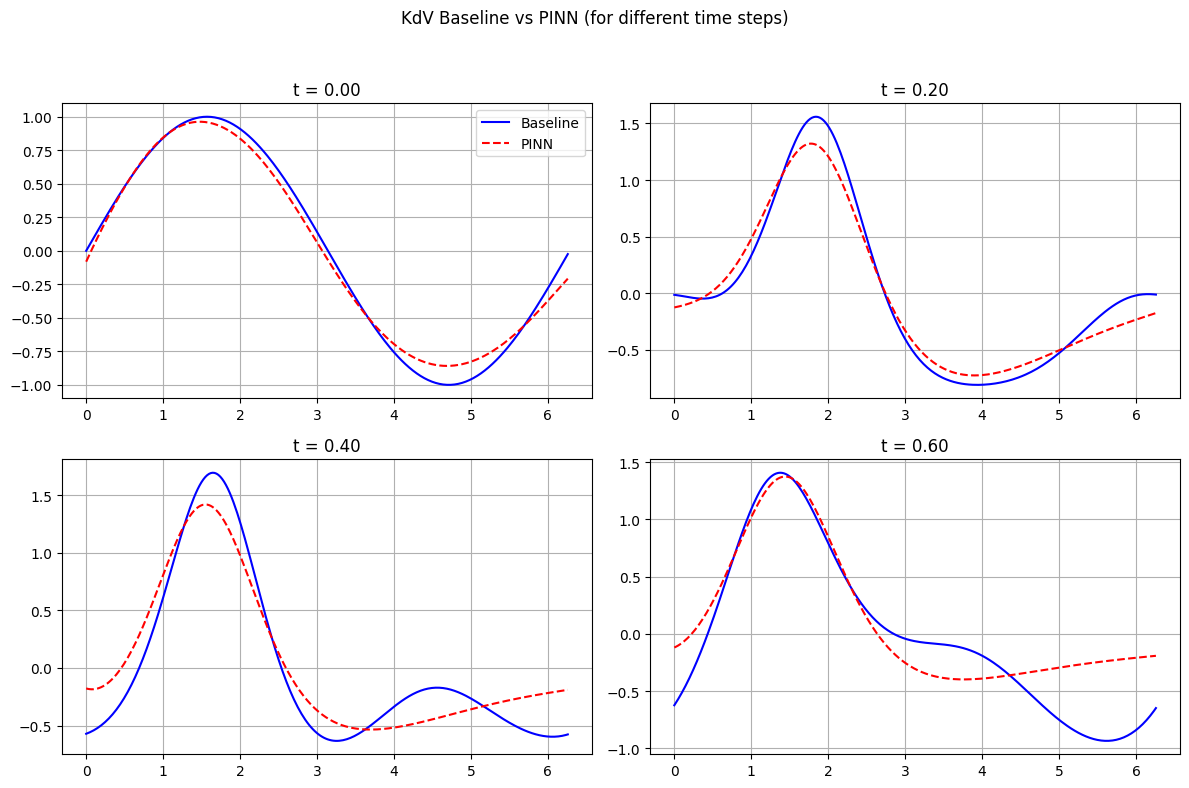

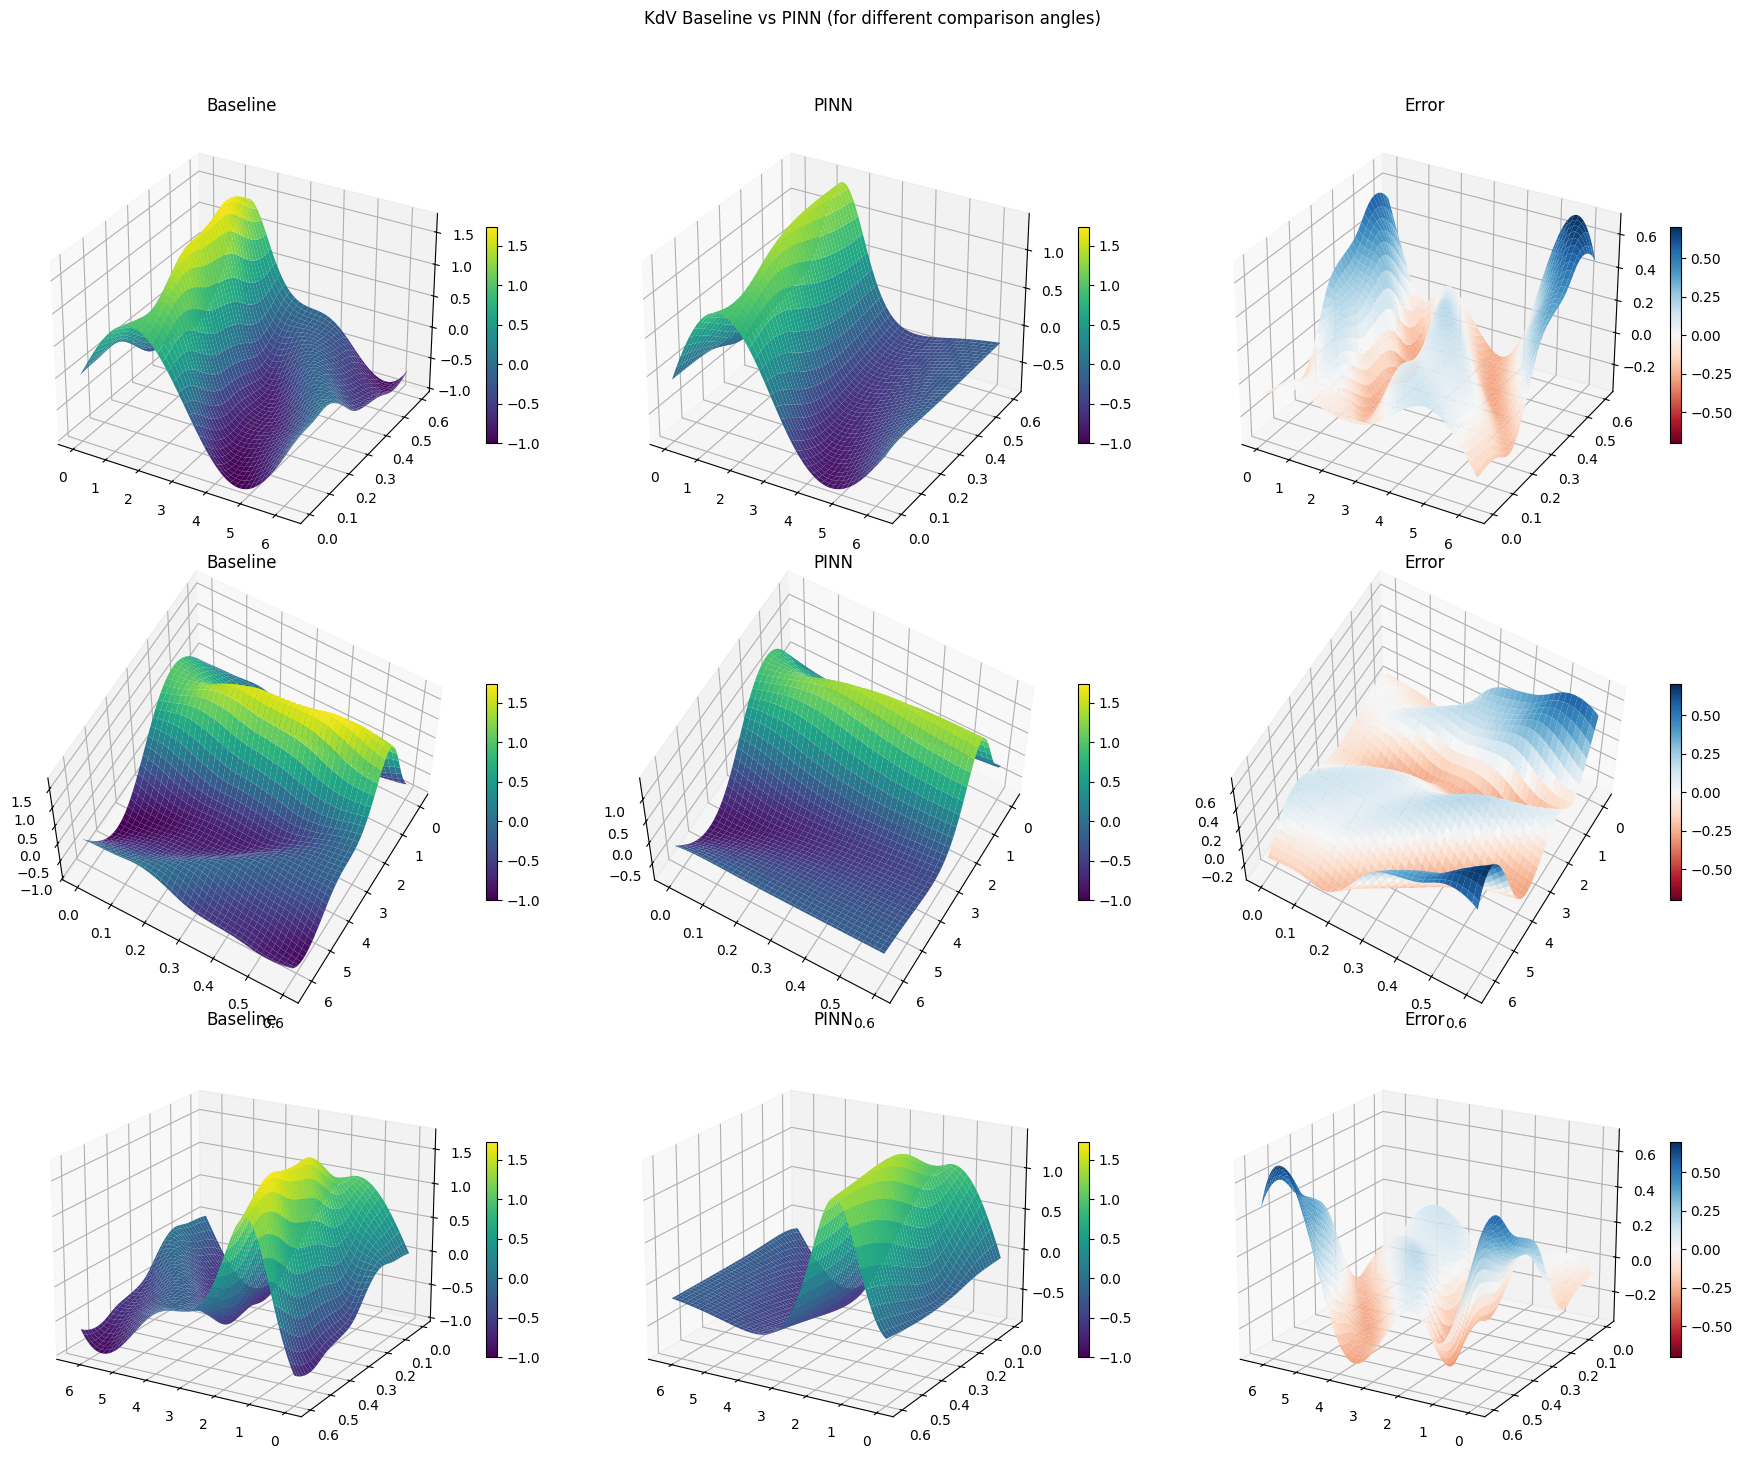

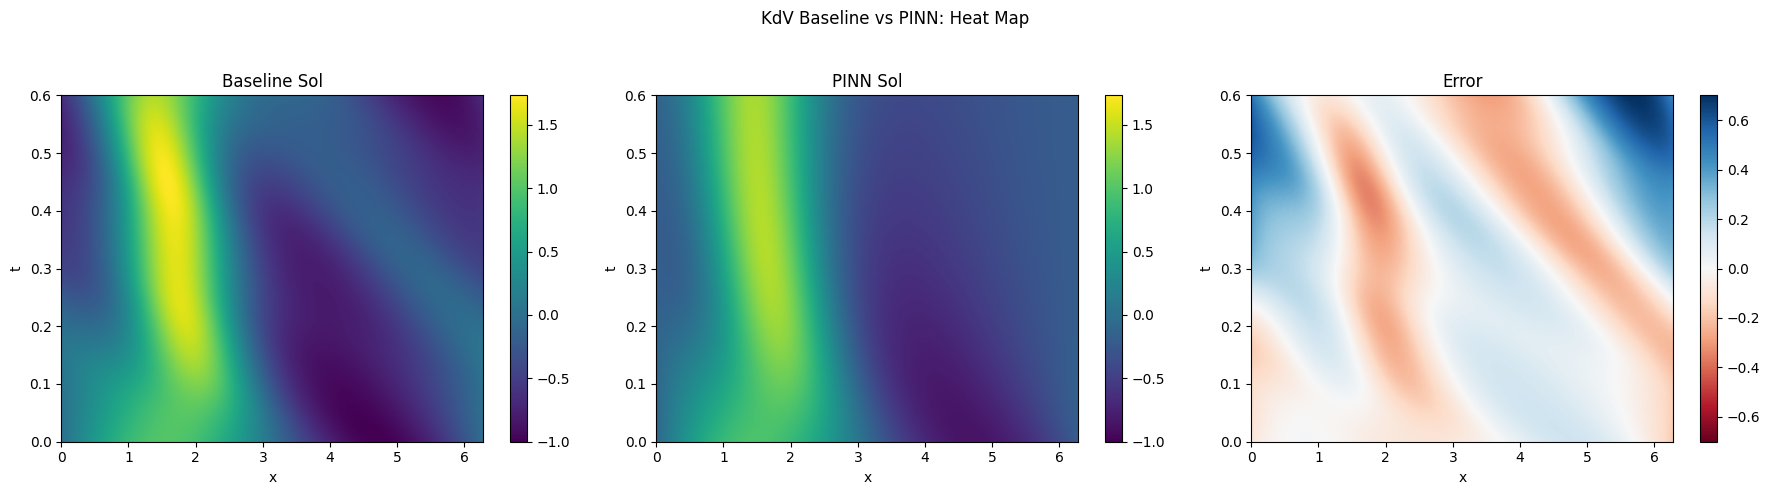

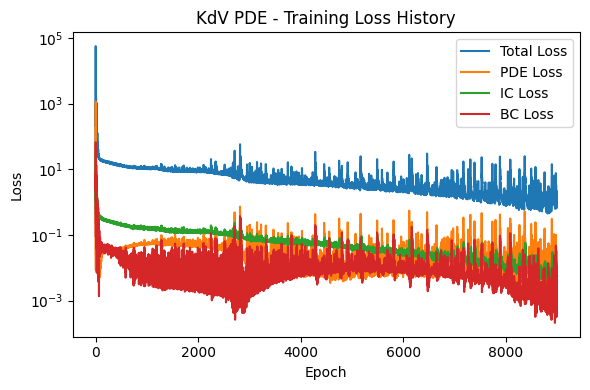

In [5]:
# ----------------------------------------
# 1) Reliable baseline solver for KdV via pseudo-spectral + BDF
# ----------------------------------------
import torch.nn.init as init

def kdv_rhs(t, u, k):
    """Right-hand side for u_t = -6*u*u_x - u_xxx on a periodic domain."""
    u_hat = np.fft.fft(u)
    u_x   = np.fft.ifft(1j * k * u_hat).real
    u_xxx = np.fft.ifft((1j * k)**3 * u_hat).real
    return -6.0 * u * u_x - u_xxx

# ----------------------------------------
# 2) PINN definition
# ----------------------------------------
class MLP(nn.Module):
    def __init__(self, in_dim, hidden_dim, out_dim):
        super().__init__()
        layers = [nn.Linear(in_dim, hidden_dim), nn.Tanh()]
        for _ in range(3):
            layers += [nn.Linear(hidden_dim, hidden_dim), nn.Tanh()]
        layers.append(nn.Linear(hidden_dim, out_dim))
        self.net = nn.Sequential(*layers)

        #every Linear layer starts with the recommended scale for its weights
        #Xavier initialization
        self.net.apply(self._init_weights)

    def forward(self, x):
        return self.net(x)

    @staticmethod
    def _init_weights(m):
        if isinstance(m, nn.Linear):
            init.xavier_uniform_(m.weight)
            init.zeros_(m.bias)

class KdV_PINN(nn.Module):
    def __init__(self, T):
        super().__init__()
        self.T = T
        self.model = MLP(2, 512, 1)
    def forward(self, x, t):
        XT = torch.cat([x, t], dim=1)
        return self.model(XT)
    def loss_pde(self, x, t):
        x = x.clone().requires_grad_(True)
        t = t.clone().requires_grad_(True)
        u = self.forward(x, t)
        u_t   = torch.autograd.grad(u, t, grad_outputs=torch.ones_like(u), create_graph=True)[0]
        u_x   = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True)[0]
        u_xx  = torch.autograd.grad(u_x, x, grad_outputs=torch.ones_like(u_x), create_graph=True)[0]
        u_xxx = torch.autograd.grad(u_xx, x, grad_outputs=torch.ones_like(u_xx), create_graph=True)[0]
        res = u_t + 6 * u * u_x + u_xxx
        return torch.mean(res**2)
    def loss_ic(self, x):
        u_pred = self.forward(x, torch.zeros_like(x))
        u_true = torch.sin(x)
        return torch.mean((u_pred - u_true)**2)
    def loss_bc(self, t):
        x0 = torch.zeros_like(t)
        x1 = torch.ones_like(t) * (2 * np.pi)
        u0 = self.forward(x0, t)
        u1 = self.forward(x1, t)
        return torch.mean((u0 - u1)**2)
    def train_model(self, epochs, lr, N_pde, N_ic, N_bc, device):
        self.to(device)
        optimizer = optim.Adam(self.parameters(), lr=lr)
        w_pde, w_ic, w_bc = 45.0, 50.0, 40.0
        history = {'pde': [], 'ic': [], 'bc': [], 'total': []}
        for ep in range(1, epochs+1):
            x_p = torch.rand(N_pde, 1, device=device) * 2 * np.pi
            t_p = torch.rand(N_pde, 1, device=device) * self.T
            x_i = torch.rand(N_ic, 1, device=device) * 2 * np.pi
            t_b = torch.rand(N_bc, 1, device=device) * self.T
            l_pde = self.loss_pde(x_p, t_p)
            l_ic  = self.loss_ic(x_i)
            l_bc  = self.loss_bc(t_b)
            loss  = w_pde * l_pde + w_ic * l_ic + w_bc * l_bc
            optimizer.zero_grad(); loss.backward(); optimizer.step()
            history['pde'].append(l_pde.item())
            history['ic'].append(l_ic.item())
            history['bc'].append(l_bc.item())
            history['total'].append(loss.item())
            if ep == 1 or ep % 1000 == 0:
                print(f"Epoch {ep:4d} | PDE {l_pde:.2e} | IC {l_ic:.2e} | BC {l_bc:.2e} | Tot {loss:.2e}")
        return history

# ----------------------------------------
# 3) Main: baseline solver + PINN + visualization
# ----------------------------------------
if __name__ == "__main__":
    total_start = time.perf_counter()
    # Domain parameters
    Lx = 2 * np.pi
    Nx = 256
    T  = 0.6
    t_points = 201

    # Spatial grid & initial condition
    x = np.linspace(0, Lx, Nx, endpoint=False)
    u0 = np.sin(x)

    # Baseline numerical solution via solve_ivp
    k = 2*np.pi * np.fft.fftfreq(Nx, d=Lx/Nx)
    t_eval = np.linspace(0, T, t_points)
    print("Computing baseline solution with solve_ivp")
    sol = solve_ivp(lambda t, u: kdv_rhs(t, u, k), [0, T], u0,
                     method='BDF', t_eval=t_eval, rtol=1e-6, atol=1e-8)
    # dt = T / (t_points-1)
    # usol = etdrk4_kdv(u0, k, dt, t_points-1)
    usol = sol.y.T  # shape (t_points, Nx)

    # Train PINN
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    pinn = KdV_PINN(T)
    history = pinn.train_model(epochs=9000, lr=1e-3, N_pde=5000, N_ic=500, N_bc=500, device=device)

    # Evaluate PINN on full mesh
    T2D, X2D = np.meshgrid(t_eval, x, indexing='ij')
    X_flat = torch.tensor(X2D.reshape(-1,1), dtype=torch.float32, device=device)
    T_flat = torch.tensor(T2D.reshape(-1,1), dtype=torch.float32, device=device)
    with torch.no_grad():
        u_pinn = pinn(X_flat, T_flat).cpu().numpy().reshape(t_points, Nx)

    # Compute error
    err = u_pinn - usol
    emax = np.max(np.abs(err))

    total_end = time.perf_counter()
    print(f"Total script execution time: {(total_end - total_start)/60:.2f} minutes.")

    # Plot baseline vs PINN cross-sections
    fig_cs, axes_cs = plt.subplots(2, 2, figsize=(12,8))
    times = [0.0, 0.2, 0.4, 0.6]
    for ax, tval in zip(axes_cs.flatten(), times):
        idx = np.searchsorted(t_eval, tval)
        ax.plot(x, usol[idx], 'b-', label='Baseline')
        ax.plot(x, u_pinn[idx], 'r--', label='PINN')
        ax.set_title(f't = {tval:.2f}'); ax.grid(True)
    axes_cs[0,0].legend()
    fig_cs.suptitle("KdV Baseline vs PINN (for different time steps)")
    plt.tight_layout(rect=[0, 0, 1, 0.95])

    # 3D visualizations from multiple angles
    angles = [(30, -60), (60, 30), (20, 120)]
    fig_multi = plt.figure(figsize=(18, 5*len(angles)))
    for i, (elev, azim) in enumerate(angles, 1):
        ax = fig_multi.add_subplot(len(angles), 3, 3*(i-1)+1, projection='3d')
        surf1 = ax.plot_surface(X2D, T2D, usol, cmap='viridis', vmin=usol.min(), vmax=usol.max())
        ax.view_init(elev=elev, azim=azim); ax.set_title(f'Baseline')
        fig_multi.colorbar(surf1, ax=ax, shrink=0.5)

        ax2 = fig_multi.add_subplot(len(angles), 3, 3*(i-1)+2, projection='3d')
        surf2 = ax2.plot_surface(X2D, T2D, u_pinn, cmap='viridis', vmin=usol.min(), vmax=usol.max())
        ax2.view_init(elev=elev, azim=azim); ax2.set_title(f'PINN')
        fig_multi.colorbar(surf2, ax=ax2, shrink=0.5)

        ax3 = fig_multi.add_subplot(len(angles), 3, 3*(i-1)+3, projection='3d')
        surf3 = ax3.plot_surface(X2D, T2D, err, cmap='RdBu', vmin=-emax, vmax=emax)
        ax3.view_init(elev=elev, azim=azim); ax3.set_title(f'Error')
        fig_multi.colorbar(surf3, ax=ax3, shrink=0.5)
    fig_multi.suptitle("KdV Baseline vs PINN (for different comparison angles)")
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

    # Heatmap comparison
    fig_hm, axes_hm = plt.subplots(1, 3, figsize=(18,5))
    for ax, Z, title, cmap, clim in zip(
        axes_hm,
        [usol, u_pinn, err],
        ['Baseline Sol', 'PINN Sol', 'Error'],
        ['viridis', 'viridis', 'RdBu'],
        [(usol.min(), usol.max()), (usol.min(), usol.max()), (-emax, emax)]
    ):
        im = ax.imshow(Z, aspect='auto', origin='lower', extent=[0, Lx, 0, T], cmap=cmap, vmin=clim[0], vmax=clim[1])
        ax.set_title(title); ax.set_xlabel('x'); ax.set_ylabel('t')
        fig_hm.colorbar(im, ax=ax)
    fig_hm.suptitle("KdV Baseline vs PINN: Heat Map")
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

    # --- Loss history plot ---
    fig_loss, ax_loss = plt.subplots(figsize=(6,4))
    ax_loss.plot(history['total'], label='Total Loss')
    ax_loss.plot(history['pde'],   label='PDE Loss')
    ax_loss.plot(history['ic'],    label='IC Loss')
    ax_loss.plot(history['bc'],    label='BC Loss')
    ax_loss.set_yscale('log')
    ax_loss.set_xlabel('Epoch')
    ax_loss.set_ylabel('Loss')
    ax_loss.legend()
    ax_loss.set_title('KdV PDE - Training Loss History')
    plt.tight_layout()
    plt.show()


# Adding Fourier features to the PINN experiment

Computing baseline solution with solve_ivp
Epoch    1 | PDE 2.53e+08 | IC 6.41e-01 | BC 5.07e-01 | Tot 3.79e+09
Epoch 1000 | PDE 1.30e+04 | IC 5.18e-01 | BC 2.01e-03 | Tot 1.94e+05
Epoch 2000 | PDE 1.26e+04 | IC 5.08e-01 | BC 1.20e-03 | Tot 1.89e+05
Epoch 3000 | PDE 5.07e+03 | IC 5.18e-01 | BC 7.59e-04 | Tot 7.60e+04
Epoch 4000 | PDE 8.88e+03 | IC 5.22e-01 | BC 4.89e-04 | Tot 1.33e+05
Epoch 5000 | PDE 7.32e+03 | IC 4.96e-01 | BC 3.01e-04 | Tot 1.10e+05
Epoch 6000 | PDE 9.18e+03 | IC 5.11e-01 | BC 1.90e-04 | Tot 1.38e+05
Epoch 7000 | PDE 6.85e+03 | IC 5.03e-01 | BC 8.58e-05 | Tot 1.03e+05
Epoch 8000 | PDE 7.02e+03 | IC 5.01e-01 | BC 4.83e-05 | Tot 1.05e+05
Epoch 9000 | PDE 2.35e+03 | IC 5.24e-01 | BC 1.57e-05 | Tot 3.53e+04
Total script execution time: 44.93 minutes.


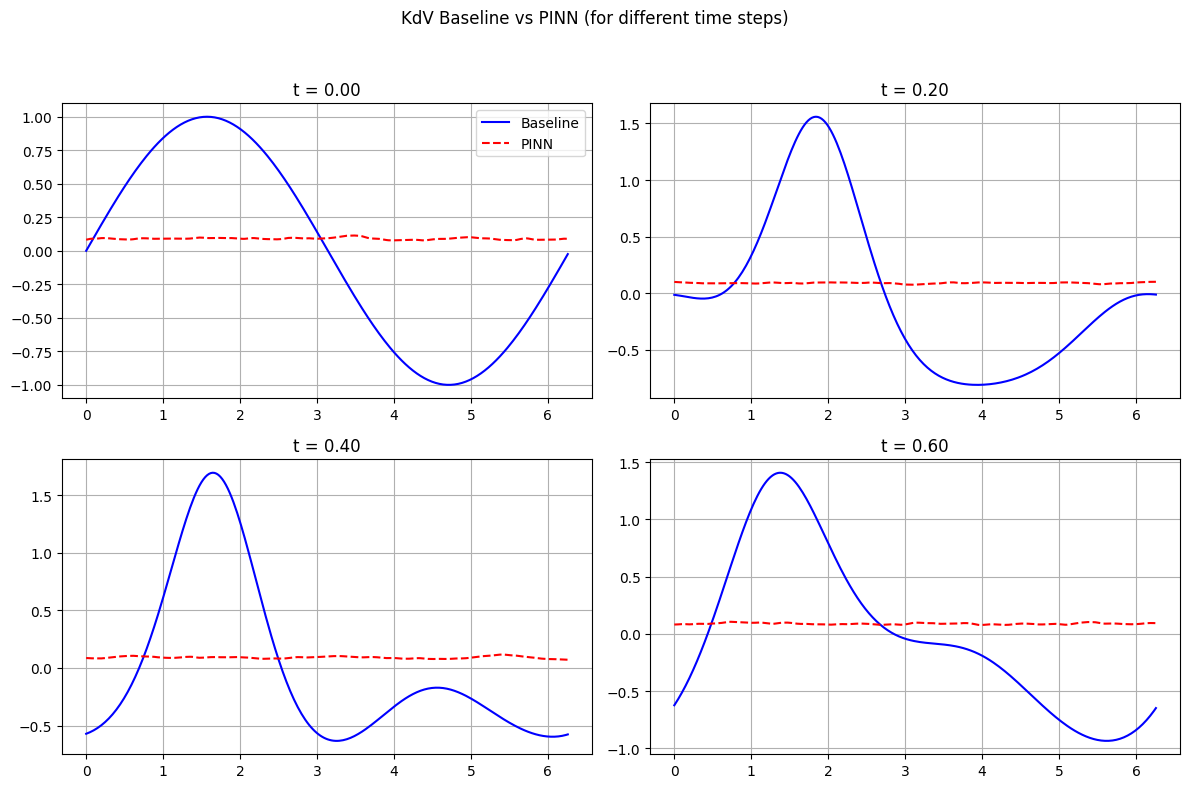

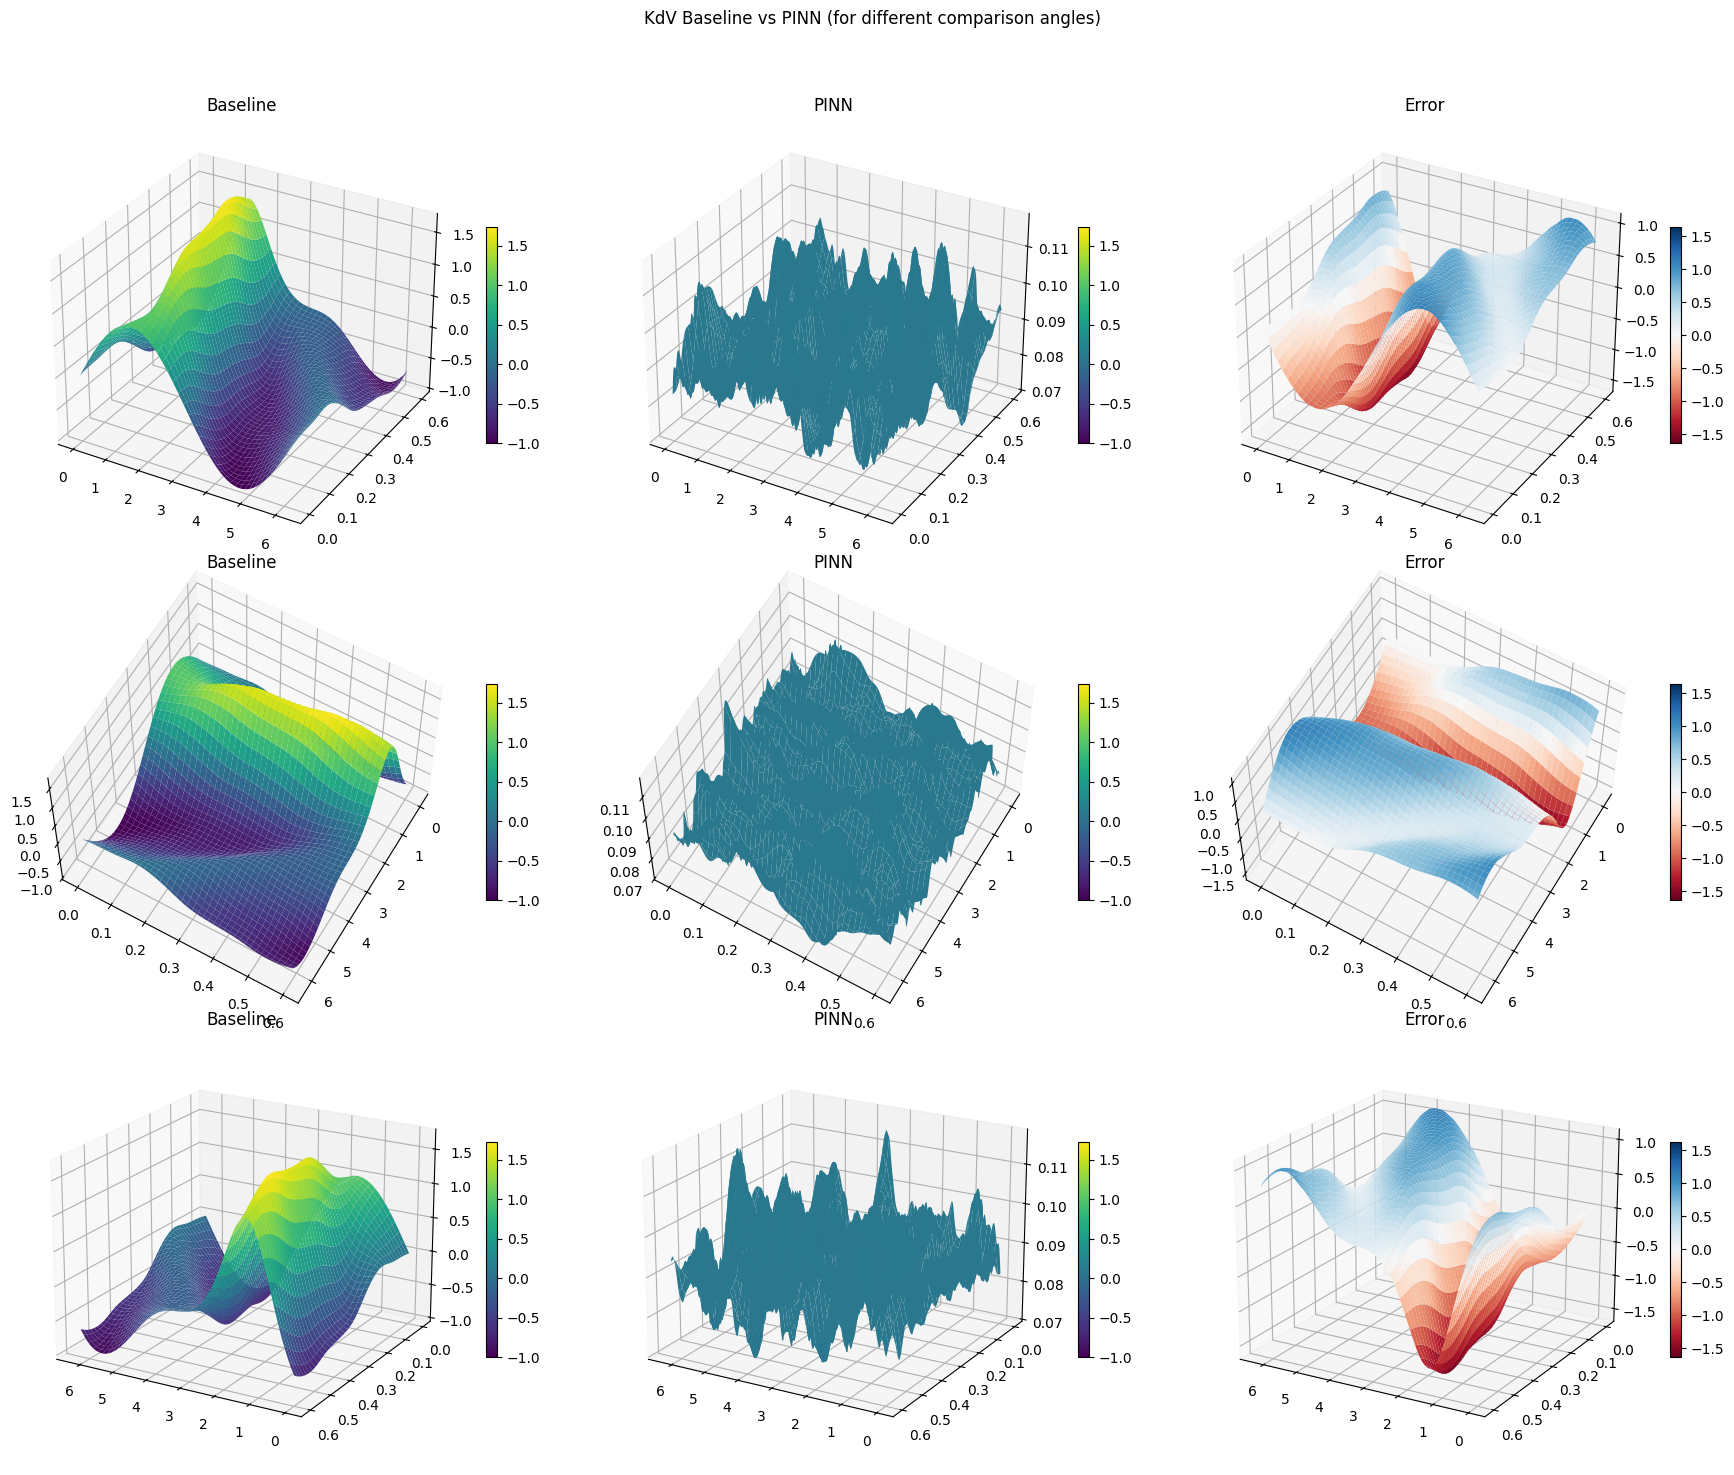

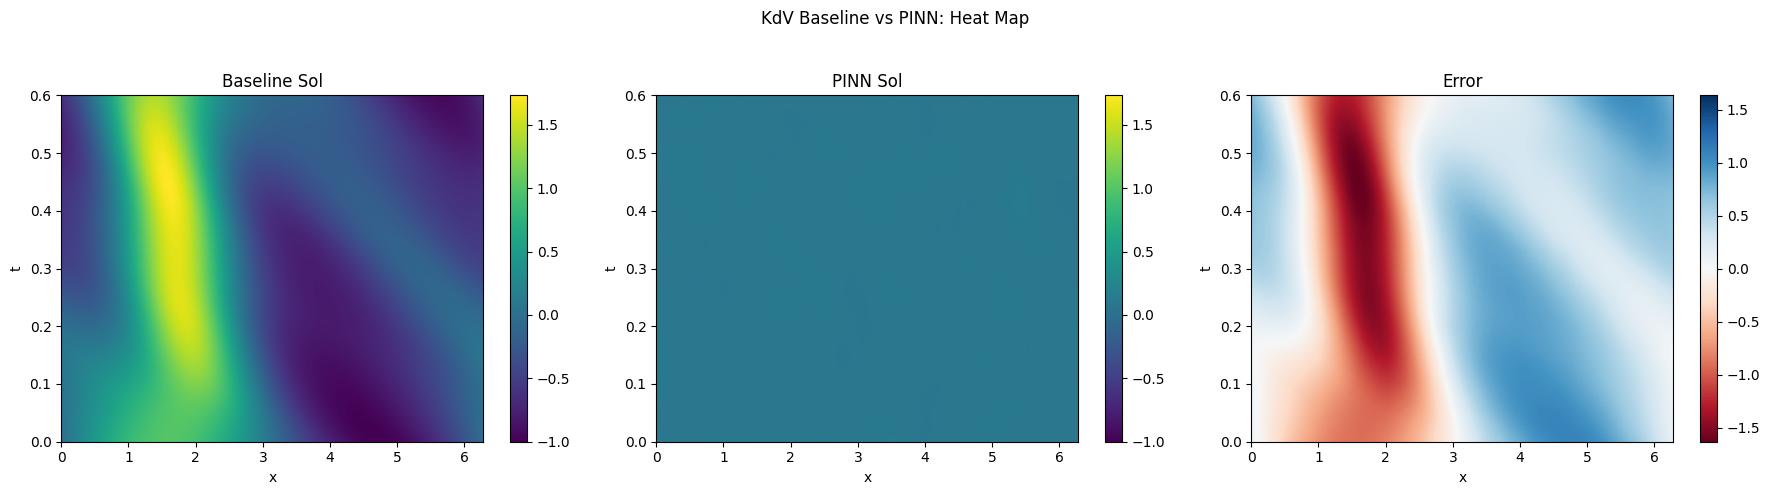

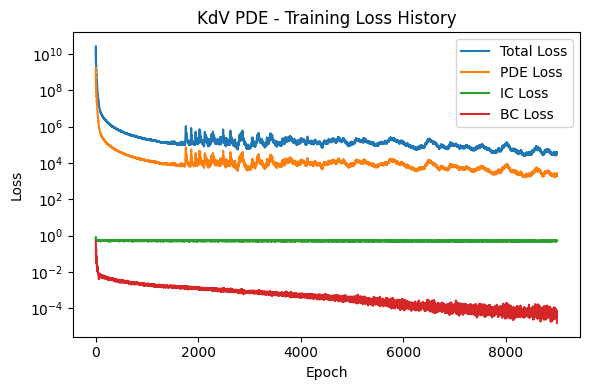

In [5]:
# ----------------------------------------
# Reliable baseline solver for KdV via pseudo-spectral + BDF
# ----------------------------------------
import torch.nn.init as init

def kdv_rhs(t, u, k):
    """Right-hand side for u_t = -6*u*u_x - u_xxx on a periodic domain."""
    u_hat = np.fft.fft(u)
    u_x   = np.fft.ifft(1j * k * u_hat).real
    u_xxx = np.fft.ifft((1j * k)**3 * u_hat).real
    return -6.0 * u * u_x - u_xxx

# ----------------------------------------
#Fourier-feature embedding layer
# ----------------------------------------
class FourierFeatureMapping(nn.Module):
    def __init__(self, in_dim, mapping_size=128, scale=np.pi):
        """
        in_dim: input dimension (here 2 for x and t)
        mapping_size: number of random features
        scale: controls the bandwidth of the features
        """
        super().__init__()
        # B: [mapping_size, in_dim], drawn from N(0, scale^2)
        B = torch.randn(mapping_size, in_dim) * scale
        self.register_buffer('B', B)  # so it's not a trainable parameter

    def forward(self, z):
        # z: [..., in_dim]
        # project: [..., mapping_size]
        proj = 2 * np.pi * z @ self.B.t()
        return torch.cat([torch.sin(proj), torch.cos(proj)], dim=-1)
        # output dim = 2 * mapping_size

# ----------------------------------------
# MLP
# ----------------------------------------
class MLP(nn.Module):
    def __init__(self, in_dim, hidden_dim, out_dim):
        super().__init__()
        layers = [nn.Linear(in_dim, hidden_dim), nn.Tanh()]
        for _ in range(3):
            layers += [nn.Linear(hidden_dim, hidden_dim), nn.Tanh()]
        layers.append(nn.Linear(hidden_dim, out_dim))
        self.net = nn.Sequential(*layers)
        self.net.apply(self._init_weights)

    def forward(self, x):
        return self.net(x)

    @staticmethod
    def _init_weights(m):
        if isinstance(m, nn.Linear):
            nn.init.xavier_uniform_(m.weight)
            nn.init.zeros_(m.bias)

# ----------------------------------------
# PINN with Fourier features
# ----------------------------------------
class KdV_PINN(nn.Module):
    def __init__(self, T, fourier_mapping_size=128, fourier_scale=np.pi):
        super().__init__()
        self.T = T

        # Embed layer: maps 2 → 2*mapping_size
        self.embed = FourierFeatureMapping(in_dim=2,
                                           mapping_size=fourier_mapping_size,
                                           scale=fourier_scale)

        # MLP now takes the embedded dimension:
        emb_dim = 2 * fourier_mapping_size
        self.model = MLP(emb_dim, hidden_dim=512, out_dim=1)

    def forward(self, x, t):
        # raw inputs:
        xt = torch.cat([x, t], dim=1)           # [..., 2]
        z = self.embed(xt)                      # [..., 2*mapping_size]
        return self.model(z)                    # [..., 1]

    def loss_pde(self, x, t):
        x = x.clone().requires_grad_(True)
        t = t.clone().requires_grad_(True)
        u = self.forward(x, t)
        u_t   = torch.autograd.grad(u, t, grad_outputs=torch.ones_like(u),
                                    create_graph=True)[0]
        u_x   = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u),
                                    create_graph=True)[0]
        u_xx  = torch.autograd.grad(u_x, x, grad_outputs=torch.ones_like(u_x),
                                    create_graph=True)[0]
        u_xxx = torch.autograd.grad(u_xx, x,
                                    grad_outputs=torch.ones_like(u_xx),
                                    create_graph=True)[0]
        res = u_t + 6 * u * u_x + u_xxx
        return torch.mean(res**2)

    def loss_ic(self, x):
        u_pred = self.forward(x, torch.zeros_like(x))
        u_true = torch.sin(x)
        return torch.mean((u_pred - u_true)**2)

    def loss_bc(self, t):
        x0 = torch.zeros_like(t)
        x1 = torch.ones_like(t) * (2 * np.pi)
        u0 = self.forward(x0, t)
        u1 = self.forward(x1, t)
        return torch.mean((u0 - u1)**2)

    def train_model(self, epochs, lr, N_pde, N_ic, N_bc, device):
        self.to(device)
        optimizer = optim.Adam(self.parameters(), lr=lr)
        w_pde, w_ic, w_bc = 15.0, 10.0, 5.0
        history = {'pde': [], 'ic': [], 'bc': [], 'total': []}
        for ep in range(1, epochs+1):
            x_p = torch.rand(N_pde, 1, device=device) * 2 * np.pi
            t_p = torch.rand(N_pde, 1, device=device) * self.T
            x_i = torch.rand(N_ic, 1, device=device) * 2 * np.pi
            t_b = torch.rand(N_bc, 1, device=device) * self.T
            l_pde = self.loss_pde(x_p, t_p)
            l_ic  = self.loss_ic(x_i)
            l_bc  = self.loss_bc(t_b)
            loss  = w_pde * l_pde + w_ic * l_ic + w_bc * l_bc

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            history['pde'].append(l_pde.item())
            history['ic'].append(l_ic.item())
            history['bc'].append(l_bc.item())
            history['total'].append(loss.item())
            if ep == 1 or ep % 1000 == 0:
                print(f"Epoch {ep:4d} | PDE {l_pde:.2e} | "
                      f"IC {l_ic:.2e} | BC {l_bc:.2e} | Tot {loss:.2e}")
        return history

# ----------------------------------------
# Main: baseline solver + PINN + visualization
# ----------------------------------------
if __name__ == "__main__":
    total_start = time.perf_counter()
    # Domain parameters
    Lx = 2 * np.pi
    Nx = 256
    T  = 0.6
    t_points = 201

    # Spatial grid & initial condition
    x = np.linspace(0, Lx, Nx, endpoint=False)
    u0 = np.sin(x)

    # Baseline numerical solution via solve_ivp
    k = 2*np.pi * np.fft.fftfreq(Nx, d=Lx/Nx)
    t_eval = np.linspace(0, T, t_points)
    print("Computing baseline solution with solve_ivp")
    sol = solve_ivp(lambda t, u: kdv_rhs(t, u, k), [0, T], u0,
                     method='BDF', t_eval=t_eval, rtol=1e-6, atol=1e-8)
    # dt = T / (t_points-1)
    # usol = etdrk4_kdv(u0, k, dt, t_points-1)
    usol = sol.y.T  # shape (t_points, Nx)

    # Train PINN
    device = 'mps'
    pinn = KdV_PINN(T)
    history = pinn.train_model(epochs=9000, lr=1e-3, N_pde=5000, N_ic=500, N_bc=500, device=device)

    # Evaluate PINN on full mesh
    T2D, X2D = np.meshgrid(t_eval, x, indexing='ij')
    X_flat = torch.tensor(X2D.reshape(-1,1), dtype=torch.float32, device=device)
    T_flat = torch.tensor(T2D.reshape(-1,1), dtype=torch.float32, device=device)
    with torch.no_grad():
        u_pinn = pinn(X_flat, T_flat).cpu().numpy().reshape(t_points, Nx)

    # Compute error
    err = u_pinn - usol
    emax = np.max(np.abs(err))

    total_end = time.perf_counter()
    print(f"Total script execution time: {(total_end - total_start)/60:.2f} minutes.")

    # Plot baseline vs PINN cross-sections
    fig_cs, axes_cs = plt.subplots(2, 2, figsize=(12,8))
    times = [0.0, 0.2, 0.4, 0.6]
    for ax, tval in zip(axes_cs.flatten(), times):
        idx = np.searchsorted(t_eval, tval)
        ax.plot(x, usol[idx], 'b-', label='Baseline')
        ax.plot(x, u_pinn[idx], 'r--', label='PINN')
        ax.set_title(f't = {tval:.2f}'); ax.grid(True)
    axes_cs[0,0].legend()
    fig_cs.suptitle("KdV Baseline vs PINN (for different time steps)")
    plt.tight_layout(rect=[0, 0, 1, 0.95])

    # 3D visualizations from multiple angles
    angles = [(30, -60), (60, 30), (20, 120)]
    fig_multi = plt.figure(figsize=(18, 5*len(angles)))
    for i, (elev, azim) in enumerate(angles, 1):
        ax = fig_multi.add_subplot(len(angles), 3, 3*(i-1)+1, projection='3d')
        surf1 = ax.plot_surface(X2D, T2D, usol, cmap='viridis', vmin=usol.min(), vmax=usol.max())
        ax.view_init(elev=elev, azim=azim); ax.set_title(f'Baseline')
        fig_multi.colorbar(surf1, ax=ax, shrink=0.5)

        ax2 = fig_multi.add_subplot(len(angles), 3, 3*(i-1)+2, projection='3d')
        surf2 = ax2.plot_surface(X2D, T2D, u_pinn, cmap='viridis', vmin=usol.min(), vmax=usol.max())
        ax2.view_init(elev=elev, azim=azim); ax2.set_title(f'PINN')
        fig_multi.colorbar(surf2, ax=ax2, shrink=0.5)

        ax3 = fig_multi.add_subplot(len(angles), 3, 3*(i-1)+3, projection='3d')
        surf3 = ax3.plot_surface(X2D, T2D, err, cmap='RdBu', vmin=-emax, vmax=emax)
        ax3.view_init(elev=elev, azim=azim); ax3.set_title(f'Error')
        fig_multi.colorbar(surf3, ax=ax3, shrink=0.5)
    fig_multi.suptitle("KdV Baseline vs PINN (for different comparison angles)")
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

    # Heatmap comparison
    fig_hm, axes_hm = plt.subplots(1, 3, figsize=(18,5))
    for ax, Z, title, cmap, clim in zip(
        axes_hm,
        [usol, u_pinn, err],
        ['Baseline Sol', 'PINN Sol', 'Error'],
        ['viridis', 'viridis', 'RdBu'],
        [(usol.min(), usol.max()), (usol.min(), usol.max()), (-emax, emax)]
    ):
        im = ax.imshow(Z, aspect='auto', origin='lower', extent=[0, Lx, 0, T], cmap=cmap, vmin=clim[0], vmax=clim[1])
        ax.set_title(title); ax.set_xlabel('x'); ax.set_ylabel('t')
        fig_hm.colorbar(im, ax=ax)
    fig_hm.suptitle("KdV Baseline vs PINN: Heat Map")
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

    # --- Loss history plot ---
    fig_loss, ax_loss = plt.subplots(figsize=(6,4))
    ax_loss.plot(history['total'], label='Total Loss')
    ax_loss.plot(history['pde'],   label='PDE Loss')
    ax_loss.plot(history['ic'],    label='IC Loss')
    ax_loss.plot(history['bc'],    label='BC Loss')
    ax_loss.set_yscale('log')
    ax_loss.set_xlabel('Epoch')
    ax_loss.set_ylabel('Loss')
    ax_loss.legend()
    ax_loss.set_title('KdV PDE - Training Loss History')
    plt.tight_layout()
    plt.show()


## Finite difference approximator test

In [3]:
Nx = 200
T  = 0.6
Lx = 2 * np.pi
x  = np.linspace(0, Lx, Nx, endpoint=False)
dx = x[1] - x[0]

# Finite-difference operators (periodic)
def deriv1(u):
    # first derivative via finite difference
    return (np.roll(u, -1) - np.roll(u, 1)) / (2 * dx)

def deriv3(u):
    # third derivative via finite difference
    return (np.roll(u, -2) - 2*np.roll(u, -1) + 2*np.roll(u, 1) - np.roll(u, 2)) / (2 * dx**3)

def make_rhs(Nx, dx):
    def rhs(t, u_flat):
        u = u_flat.reshape(Nx)
        u_x   = deriv1(u)
        u_xxx = deriv3(u)
        return (-6 * u * u_x - u_xxx).ravel()
    return rhs

# ----------------------------------------
# 2) PINN definition
# ----------------------------------------
class MLP(nn.Module):
    def __init__(self, in_dim, hidden_dim, out_dim):
        super().__init__()
        layers = [nn.Linear(in_dim, hidden_dim), nn.Tanh()]
        for _ in range(3):
            layers += [nn.Linear(hidden_dim, hidden_dim), nn.Tanh()]
        layers.append(nn.Linear(hidden_dim, out_dim))
        self.net = nn.Sequential(*layers)
    def forward(self, x):
        return self.net(x)

class KdV_PINN(nn.Module):
    def __init__(self, T):
        super().__init__()
        self.T = T
        self.model = MLP(6, 64, 1)
    def forward(self, x, t):
        XT = torch.cat([x, t], dim=1)
        return self.model(XT)
    def loss_pde(self, x, t):
        x = x.clone().requires_grad_(True)
        t = t.clone().requires_grad_(True)
        u = self.forward(x, t)
        u_t   = torch.autograd.grad(u, t, grad_outputs=torch.ones_like(u), create_graph=True)[0]
        u_x   = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True)[0]
        u_xx  = torch.autograd.grad(u_x, x, grad_outputs=torch.ones_like(u_x), create_graph=True)[0]
        u_xxx = torch.autograd.grad(u_xx, x, grad_outputs=torch.ones_like(u_xx), create_graph=True)[0]
        res = u_t + 6 * u * u_x + u_xxx
        return torch.mean(res**2)
    def loss_ic(self, x):
        u_pred = self.forward(x, torch.zeros_like(x))
        u_true = torch.sin(x)
        return torch.mean((u_pred - u_true)**2)
    def loss_bc(self, t):
        x0 = torch.zeros_like(t)
        x1 = torch.ones_like(t) * (2 * np.pi)
        u0 = self.forward(x0, t)
        u1 = self.forward(x1, t)
        return torch.mean((u0 - u1)**2)
    def train_model(self, epochs, lr, N_pde, N_ic, N_bc, device):
        self.to(device)
        optimizer = optim.Adam(self.parameters(), lr=lr)
        w_pde, w_ic, w_bc = 45.0, 50.0, 40.0
        history = {'pde': [], 'ic': [], 'bc': [], 'total': []}
        for ep in range(1, epochs+1):
            x_p = torch.rand(N_pde, 1, device=device) * 2 * np.pi
            t_p = torch.rand(N_pde, 1, device=device) * self.T
            x_i = torch.rand(N_ic, 1, device=device) * 2 * np.pi
            t_b = torch.rand(N_bc, 1, device=device) * self.T
            l_pde = self.loss_pde(x_p, t_p)
            l_ic  = self.loss_ic(x_i)
            l_bc  = self.loss_bc(t_b)
            loss  = w_pde * l_pde + w_ic * l_ic + w_bc * l_bc
            optimizer.zero_grad(); loss.backward(); optimizer.step()
            history['pde'].append(l_pde.item())
            history['ic'].append(l_ic.item())
            history['bc'].append(l_bc.item())
            history['total'].append(loss.item())
            if ep == 1 or ep % 1000 == 0:
                print(f"Epoch {ep:4d} | PDE {l_pde:.2e} | IC {l_ic:.2e} | BC {l_bc:.2e} | Tot {loss:.2e}")
        return history


# ----------------------------------------
# 3) Main: baseline solver + PINN + visualization
# ----------------------------------------
if __name__ == "__main__":
    total_start = time.perf_counter()
    # Domain parameters
    Lx = 2 * np.pi
    Nx = 256
    T  = 0.6
    t_points = 201

    # Spatial grid & initial condition
    x = np.linspace(0, Lx, Nx, endpoint=False)
    # Initial condition: single sine wave
    u0 = np.sin(x)

    # Baseline numerical solution via solve_ivp
    t_eval = np.linspace(0, T, t_points)
    rhs = make_rhs(Nx, dx) #convert the pde into an ode
    print("Computing baseline solution with solve_ivp")
    # sol = solve_ivp(lambda t, u: kdv_rhs(t, u, k), [0, T], u0,
    #                  method='BDF', t_eval=t_eval, rtol=1e-6, atol=1e-8) #BDF discarded
    sol = solve_ivp(rhs, [0, T], u0,
                method='RK45', t_eval=t_eval, rtol=1e-6, atol=1e-8)
    usol = sol.y.T  # shape (t_points, Nx)

    # Train PINN
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    pinn = KdV_PINN(T)
    history = pinn.train_model(epochs=6000, lr=1e-3, N_pde=5000, N_ic=600, N_bc=600, device=device)

    # Evaluate PINN on full mesh
    T2D, X2D = np.meshgrid(t_eval, x, indexing='ij')
    X_flat = torch.tensor(X2D.reshape(-1,1), dtype=torch.float32, device=device)
    T_flat = torch.tensor(T2D.reshape(-1,1), dtype=torch.float32, device=device)
    with torch.no_grad():
        u_pinn = pinn(X_flat, T_flat).cpu().numpy().reshape(t_points, Nx)

    # Compute error
    err = u_pinn - usol
    emax = np.max(np.abs(err))

    total_end = time.perf_counter()
    print(f"Total script execution time: {(total_end - total_start)/60:.2f} minutes.")

    # Plot baseline vs PINN cross-sections
    fig_cs, axes_cs = plt.subplots(2, 2, figsize=(12,8))
    times = [0.0, 0.2, 0.4, 0.6]
    for ax, tval in zip(axes_cs.flatten(), times):
        idx = np.searchsorted(t_eval, tval)
        ax.plot(x, usol[idx], 'b-', label='Baseline')
        ax.plot(x, u_pinn[idx], 'r--', label='PINN')
        ax.set_title(f't = {tval:.2f}'); ax.grid(True)
    axes_cs[0,0].legend()
    fig_cs.suptitle("KdV Baseline vs PINN (for different time steps)")
    plt.tight_layout(rect=[0, 0, 1, 0.95])

    # 3D visualizations from multiple angles
    angles = [(30, -60), (60, 30), (20, 120)]
    fig_multi = plt.figure(figsize=(18, 5*len(angles)))
    for i, (elev, azim) in enumerate(angles, 1):
        ax = fig_multi.add_subplot(len(angles), 3, 3*(i-1)+1, projection='3d')
        surf1 = ax.plot_surface(X2D, T2D, usol, cmap='viridis', vmin=usol.min(), vmax=usol.max())
        ax.view_init(elev=elev, azim=azim); ax.set_title(f'Baseline')
        fig_multi.colorbar(surf1, ax=ax, shrink=0.5)

        ax2 = fig_multi.add_subplot(len(angles), 3, 3*(i-1)+2, projection='3d')
        surf2 = ax2.plot_surface(X2D, T2D, u_pinn, cmap='viridis', vmin=usol.min(), vmax=usol.max())
        ax2.view_init(elev=elev, azim=azim); ax2.set_title(f'PINN')
        fig_multi.colorbar(surf2, ax=ax2, shrink=0.5)

        ax3 = fig_multi.add_subplot(len(angles), 3, 3*(i-1)+3, projection='3d')
        surf3 = ax3.plot_surface(X2D, T2D, err, cmap='RdBu', vmin=-emax, vmax=emax)
        ax3.view_init(elev=elev, azim=azim); ax3.set_title(f'Error')
        fig_multi.colorbar(surf3, ax=ax3, shrink=0.5)
    fig_multi.suptitle("KdV Baseline vs PINN (for different comparison angles)")
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

    # Heatmap comparison
    fig_hm, axes_hm = plt.subplots(1, 3, figsize=(18,5))
    for ax, Z, title, cmap, clim in zip(
        axes_hm,
        [usol, u_pinn, err],
        ['Baseline Sol', 'PINN Sol', 'Error'],
        ['viridis', 'viridis', 'RdBu'],
        [(usol.min(), usol.max()), (usol.min(), usol.max()), (-emax, emax)]
    ):
        im = ax.imshow(Z, aspect='auto', origin='lower', extent=[0, Lx, 0, T], cmap=cmap, vmin=clim[0], vmax=clim[1])
        ax.set_title(title); ax.set_xlabel('x'); ax.set_ylabel('t')
        fig_hm.colorbar(im, ax=ax)
    fig_hm.suptitle("KdV Baseline vs PINN: Heat Map")
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

    # --- Loss history plot ---
    fig_loss, ax_loss = plt.subplots(figsize=(6,4))
    ax_loss.plot(history['total'], label='Total Loss')
    ax_loss.plot(history['pde'],   label='PDE Loss')
    ax_loss.plot(history['ic'],    label='IC Loss')
    ax_loss.plot(history['bc'],    label='BC Loss')
    ax_loss.set_yscale('log')
    ax_loss.set_xlabel('Epoch')
    ax_loss.set_ylabel('Loss')
    ax_loss.legend()
    ax_loss.set_title('Training Loss History')
    plt.tight_layout()
    plt.show()


Computing baseline solution with solve_ivp


RuntimeError: mat1 and mat2 shapes cannot be multiplied (5000x2 and 6x64)